In [1]:
import os

# home_dir = '/content/gdrive/My Drive/AChina' 
# home_dir = '/hy-tmp'
# os.chdir(home_dir)
# pwd

!pip install tqdm 
!pip install fire

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import os
import warnings
import sys

import fire

# warnings.filterwarnings("ignore")  # avoid printing out absolute paths

# os.chdir("../../..")

!pip install scipy
!pip install torch 
!pip install pytorch_lightning==1.9.0 pytorch_forecasting

import copy
from pathlib import Path
import warnings

import time

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAPE, SMAPE, PoissonLoss, QuantileLoss, RMSE, MAE
from matplotlib import pyplot as plt
from pytorch_lightning.utilities.model_summary import summarize
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging
from matplotlib import pyplot as plt

from multiprocessing import Pool, freeze_support

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 226.4 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: pytorch_lightning
    Found existing installation: pytorch-lightning 1.9.4
    Uninstalling pytorch-lightning-1.9.4:
      Successfully uninstalled pytorch-lightning-1.9.4
You should consider upgrading 

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
home_dir = '/hy-tmp'        
os.chdir(home_dir)

!pwd

# !ls

pl.seed_everything(1234, workers=True)

# from google.colab import drive
# drive.mount('/content/gdrive/')

# !ls

# home_dir = '/content/gdrive/My Drive/AChina'        
# os.chdir(home_dir)
# !pwd

/hy-tmp


Global seed set to 1234


1234

In [6]:
data = np.load('A0mod_A0cr[rice]-yr[2005_2010_2017]-en[A0_RMSE_cyclic]-bs[128]-lr[0.01]_predict.npz')

for ks in data.keys():
    print(ks)


actuals
predictions
prediction
encoder_target
decoder_target


In [7]:
print(data['prediction'].shape, data['encoder_target'].shape, data['decoder_target'].shape)
print( np.asarray(data['prediction'][0,0,0]) )
print( np.asarray(data['prediction'][0]) )

(108, 16, 1) (108, 18) (108, 16)
0.6747625
[[0.6747625 ]
 [0.67116094]
 [0.6720427 ]
 [0.6727123 ]
 [0.66985416]
 [0.67090654]
 [0.6708364 ]
 [0.6716913 ]
 [0.6691834 ]
 [0.6710021 ]
 [0.6701113 ]
 [0.667367  ]
 [0.66907   ]
 [0.6699088 ]
 [0.6696228 ]
 [0.67332727]]


In [8]:
MOD_BINS = 128
FAM_BINS = 64
datasetfile = f'data/ALIM{MOD_BINS}F{FAM_BINS}DATASET_rice.csv'
alidata = pd.read_csv(os.path.join(home_dir,datasetfile))

alidata.head()

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,month,MOD_month_t,time_idx,Unnamed: 0.1.1.1,county,year,b0b0,...,Wind_f_tavg_53,Wind_f_tavg_54,Wind_f_tavg_55,Wind_f_tavg_56,Wind_f_tavg_57,Wind_f_tavg_58,Wind_f_tavg_59,Wind_f_tavg_60,Wind_f_tavg_61,Wind_f_tavg_62
0,0,0,0,1,0,0,0,0,2003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0,1,1,1,0,0,2003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,0,1,2,2,0,0,2003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3,0,2,0,3,0,0,2003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,0,2,1,4,0,0,2003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]


/tmp/ipykernel_547713/2667981197.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))


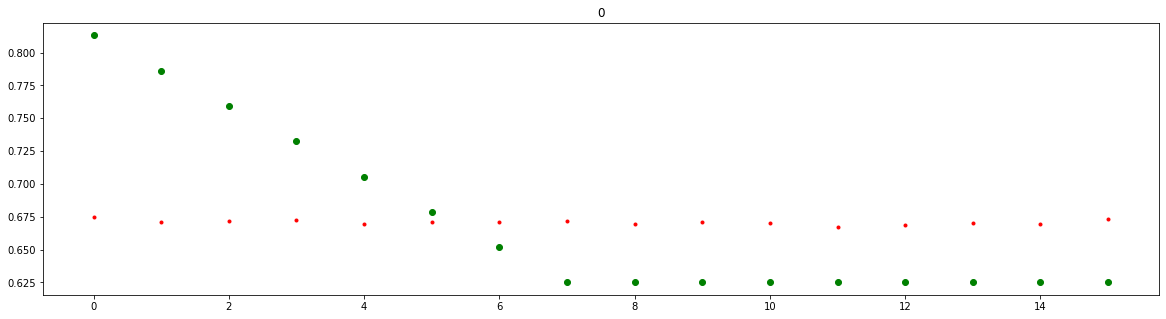

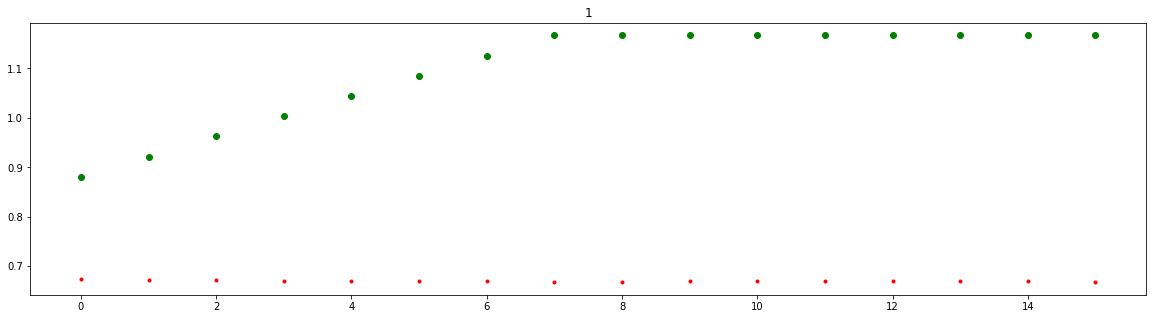

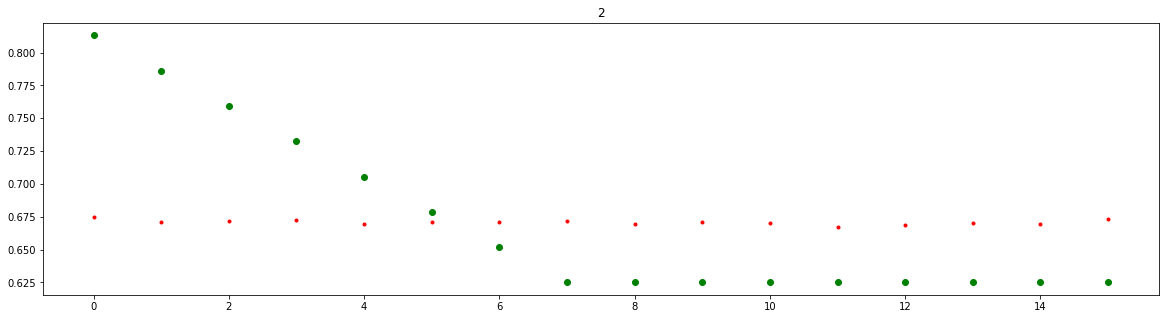

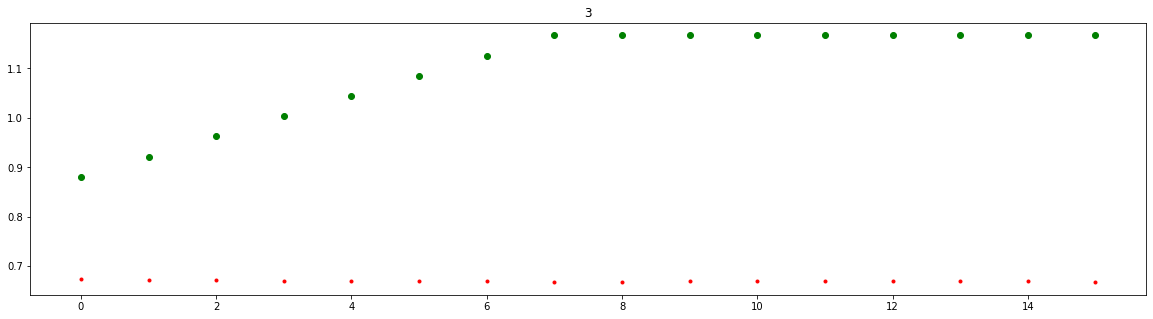

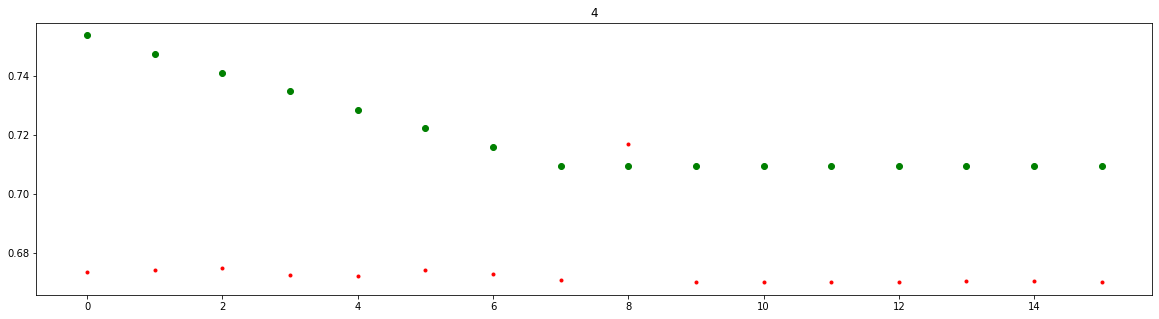

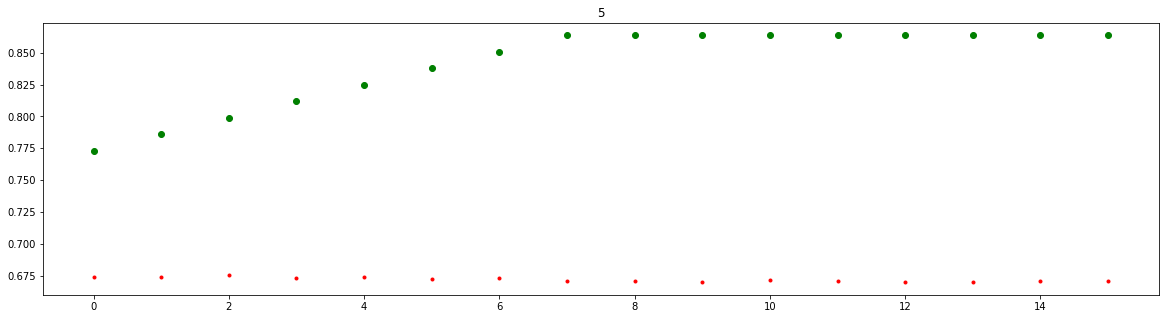

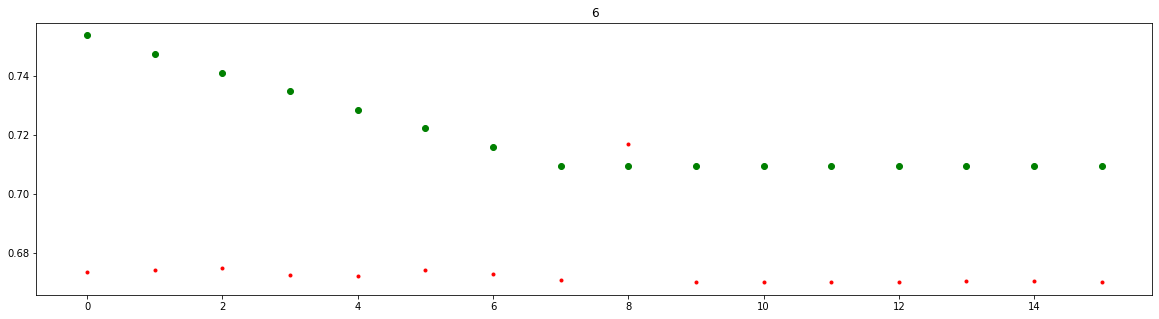

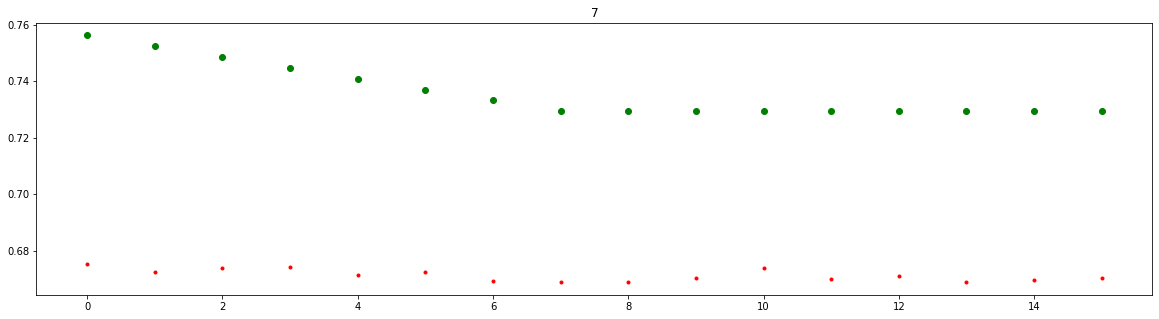

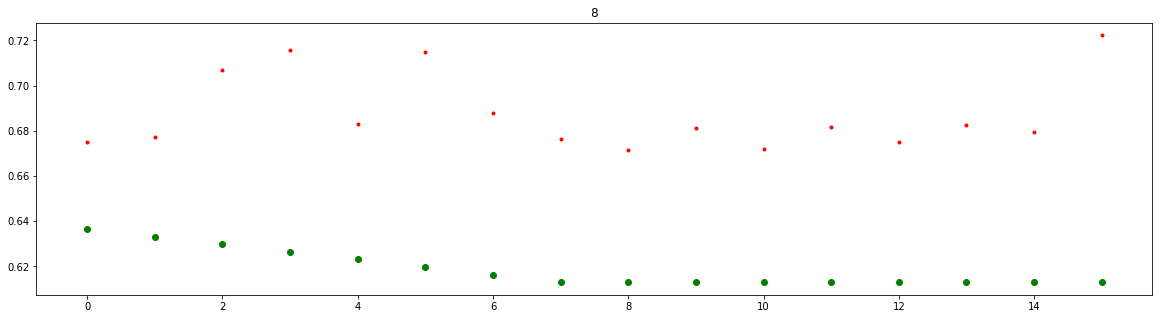

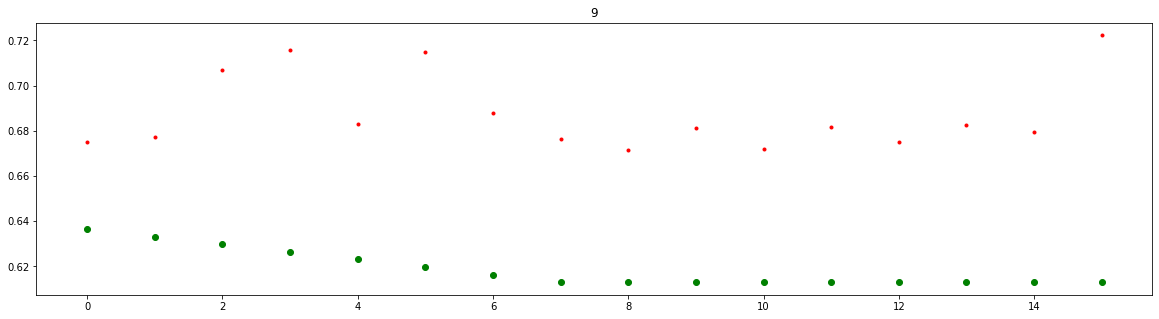

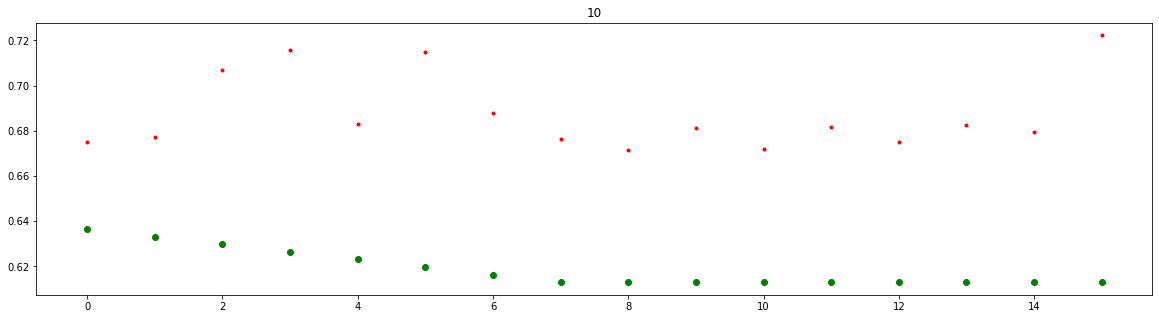

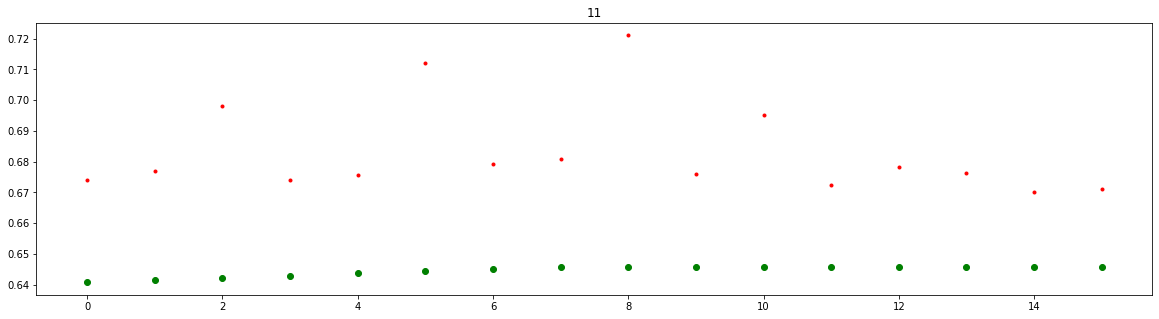

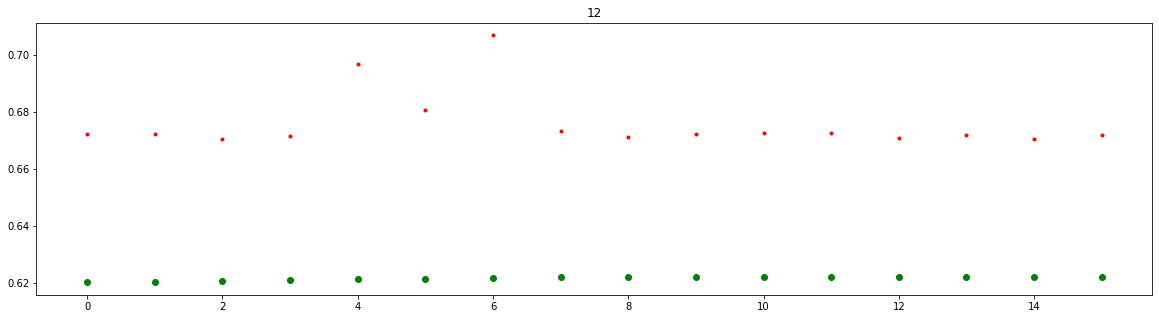

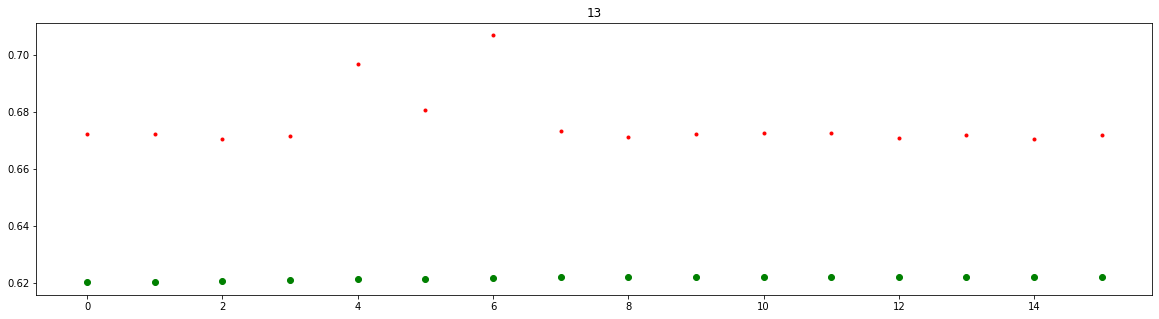

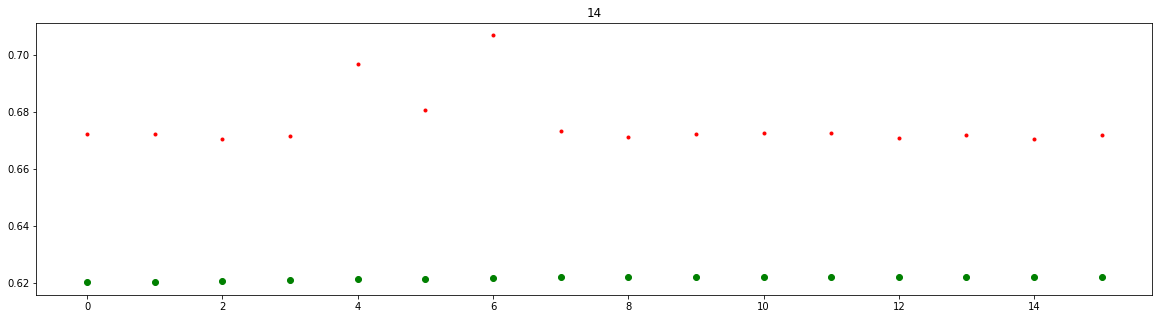

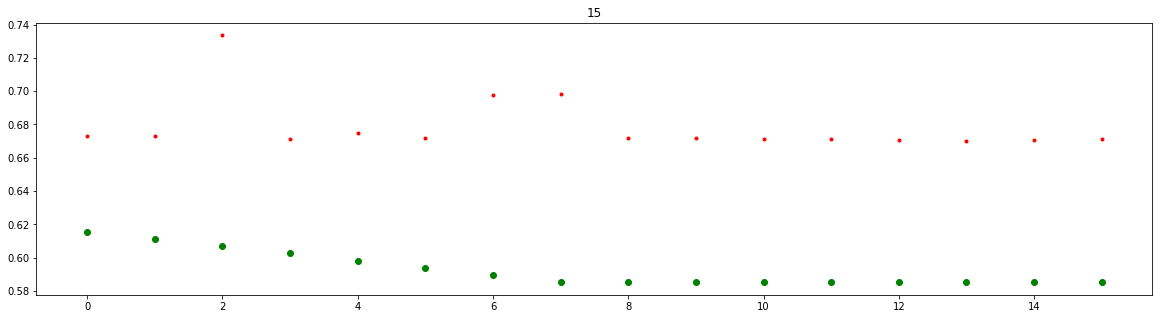

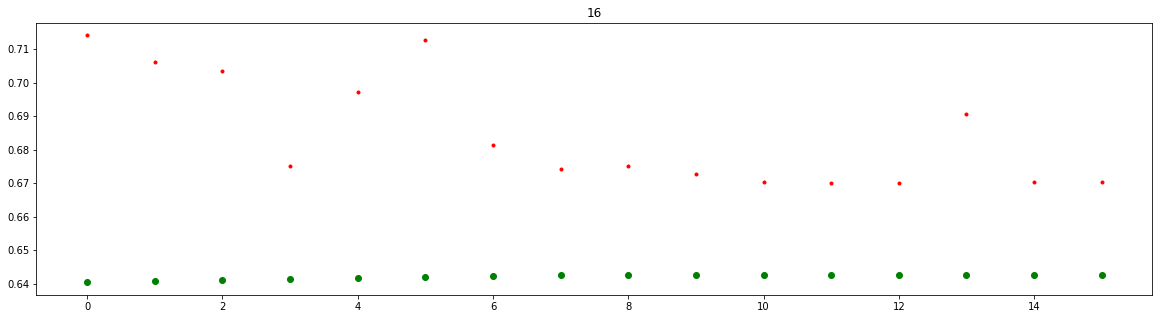

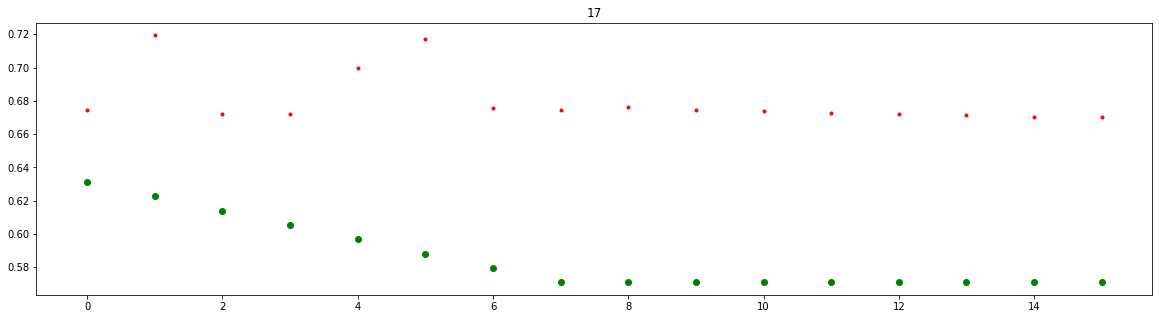

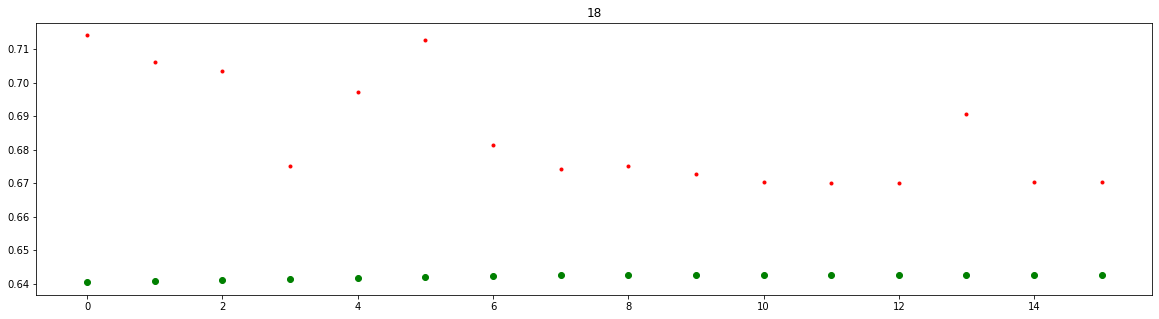

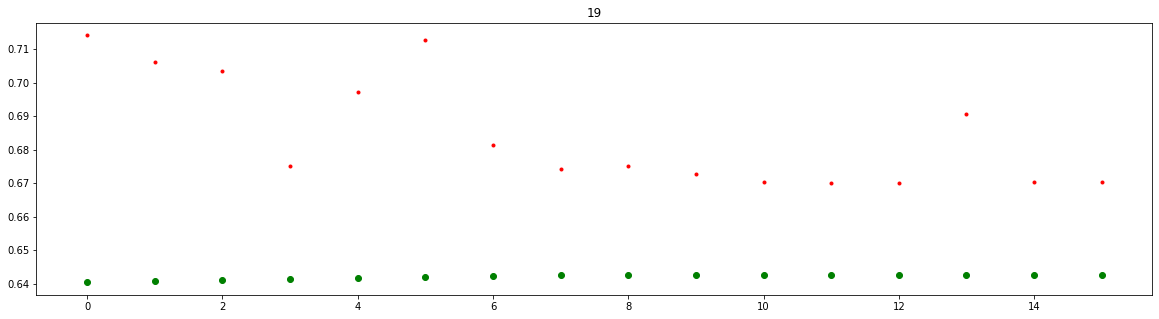

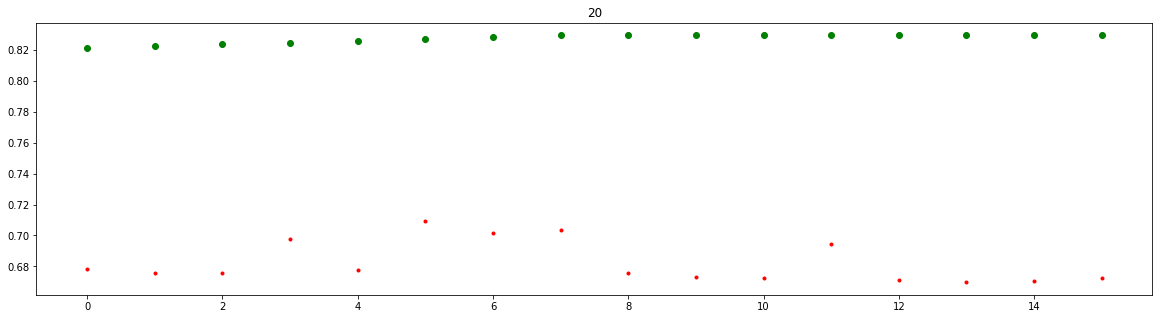

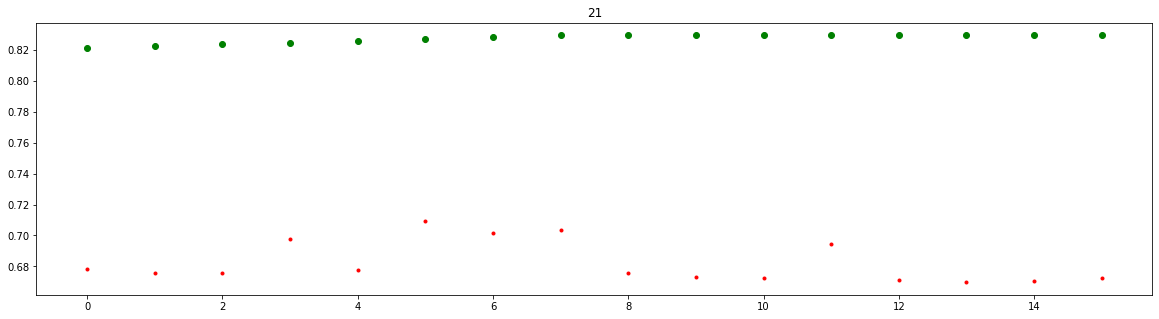

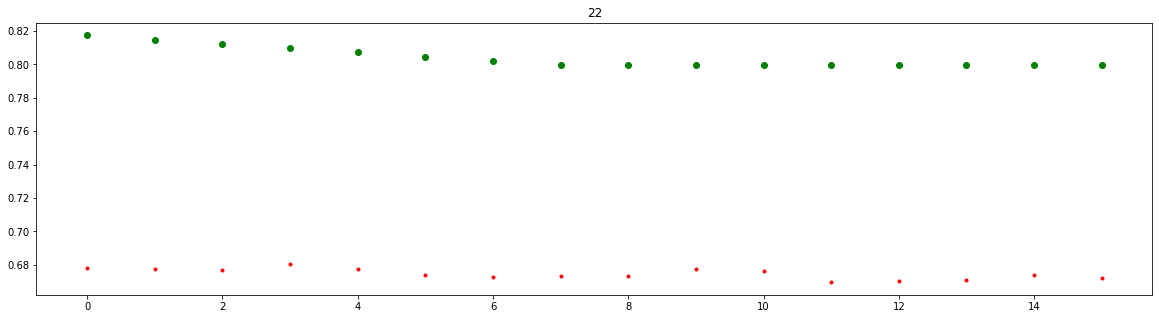

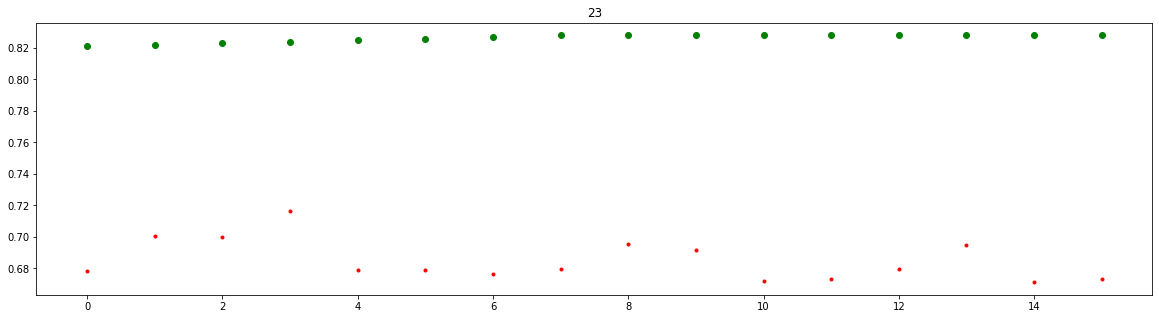

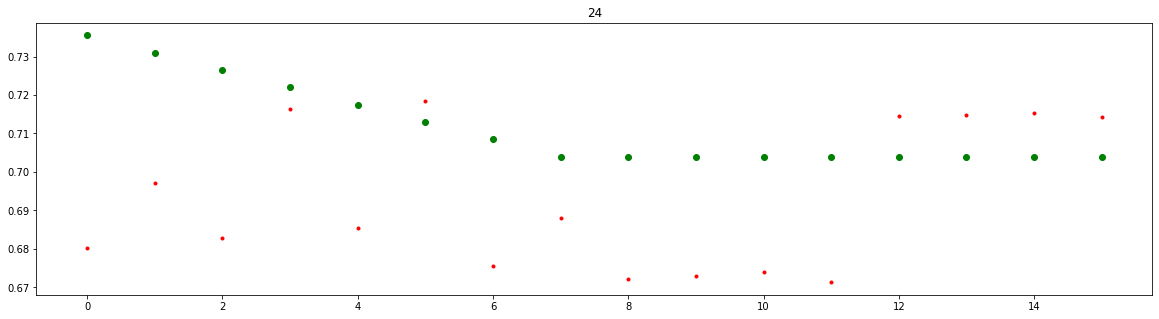

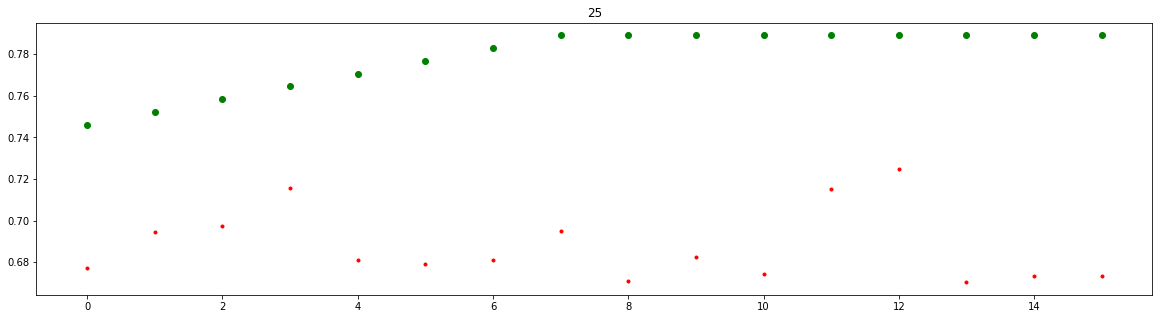

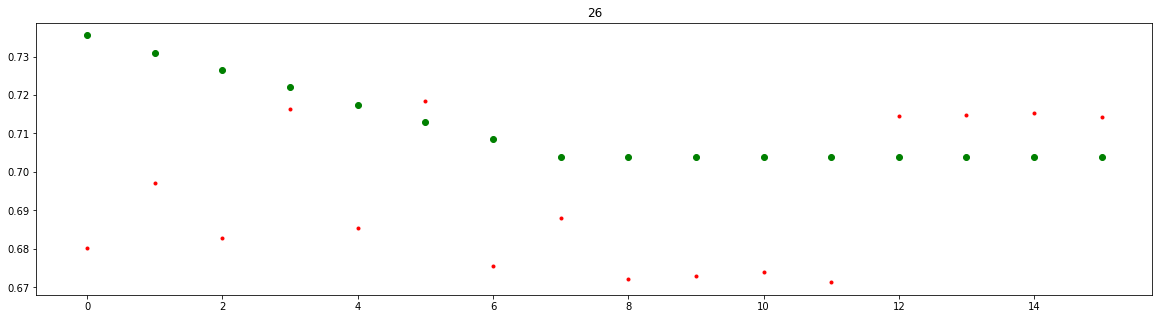

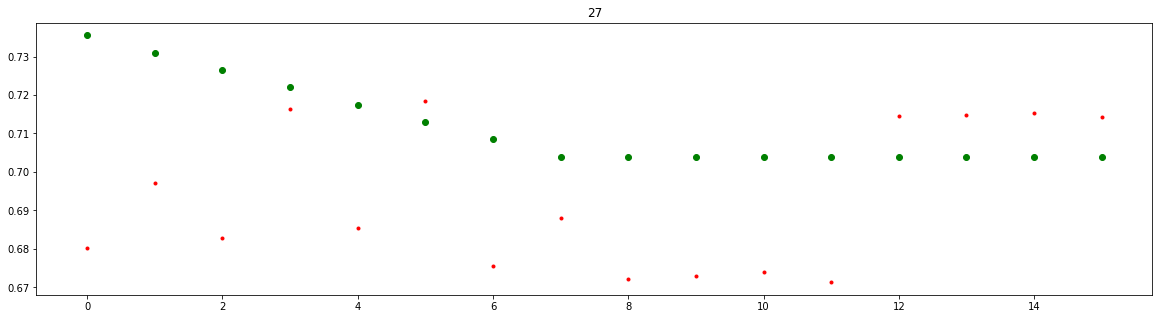

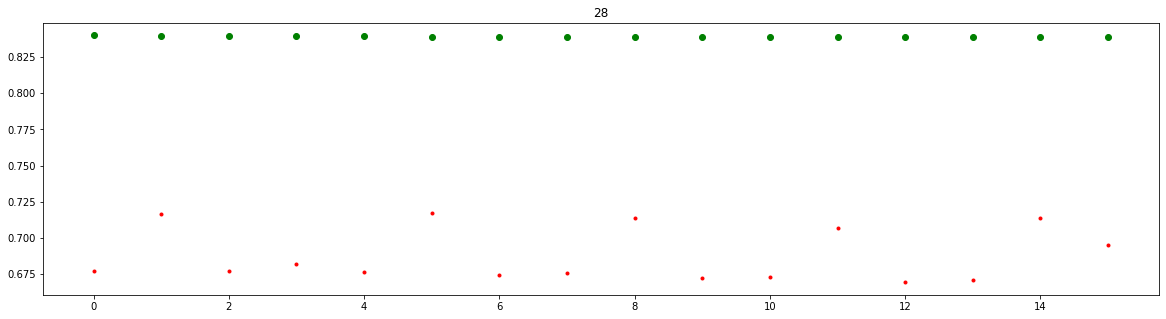

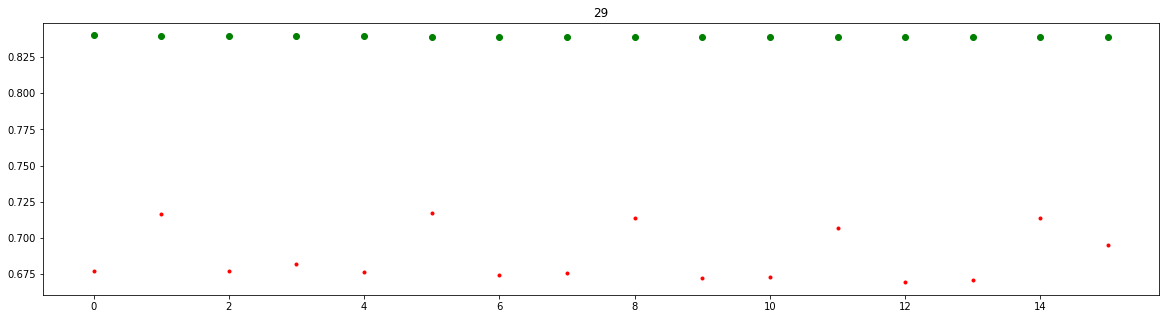

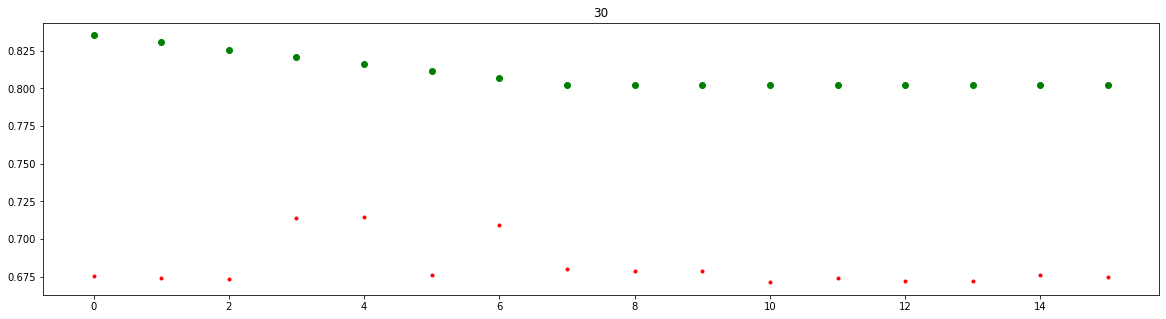

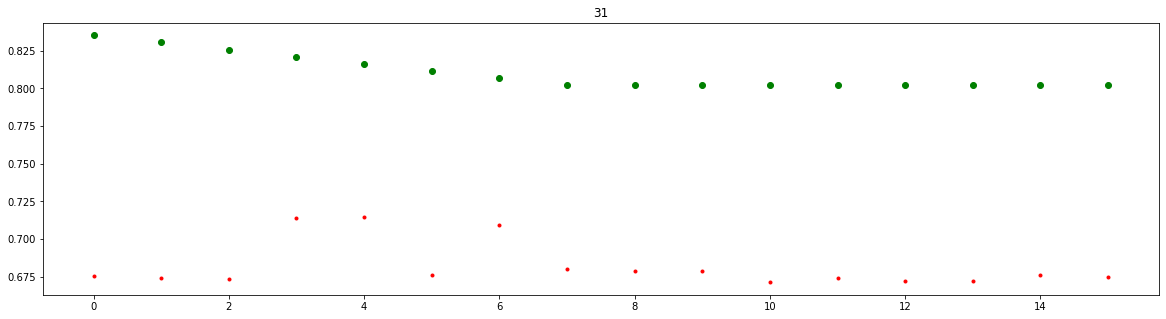

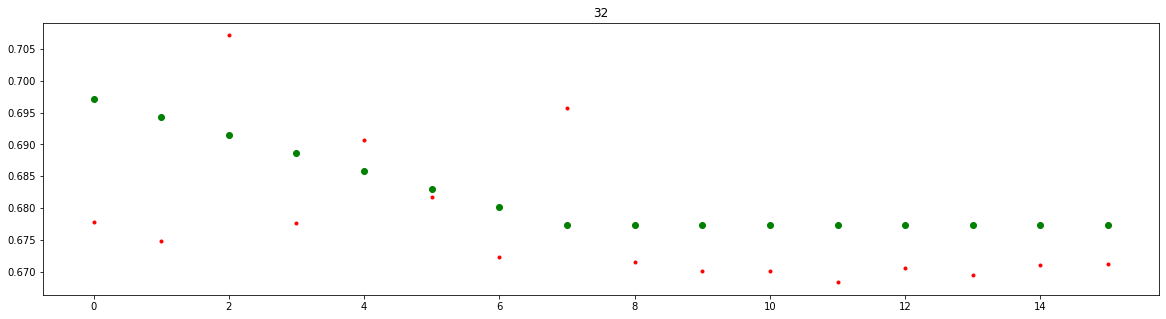

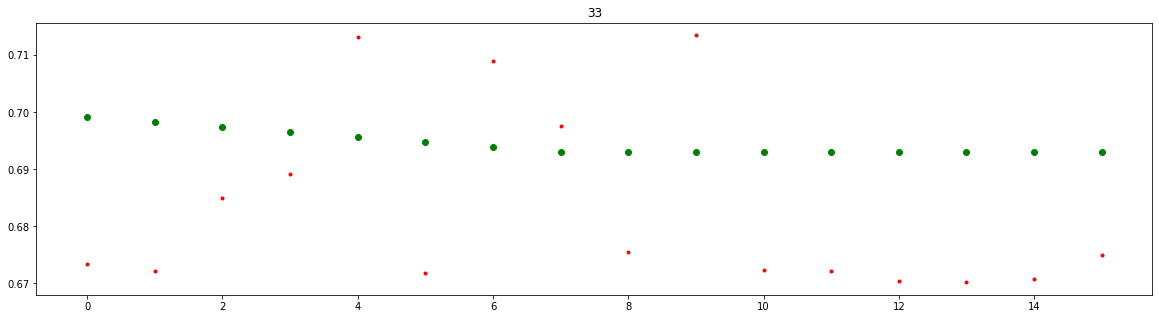

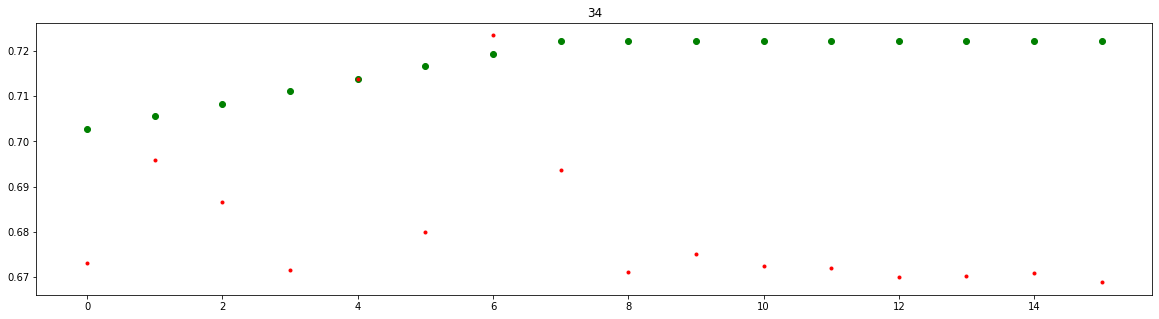

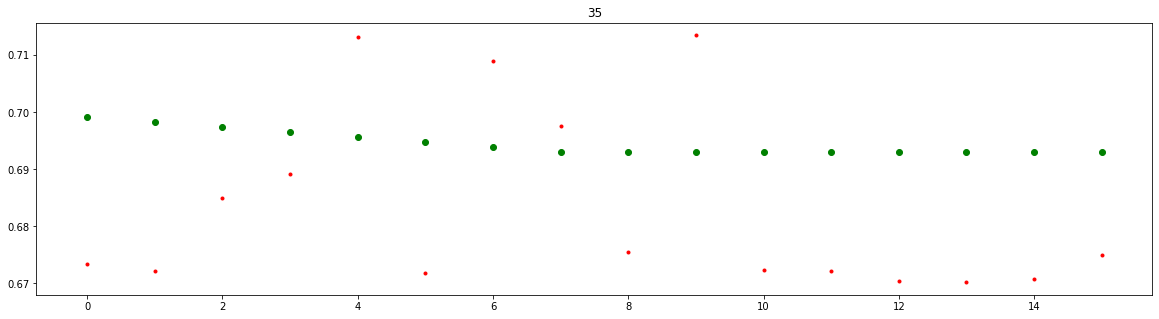

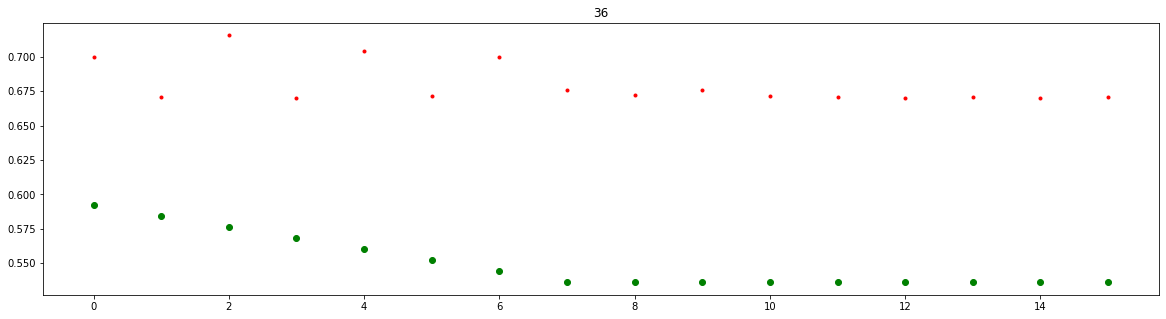

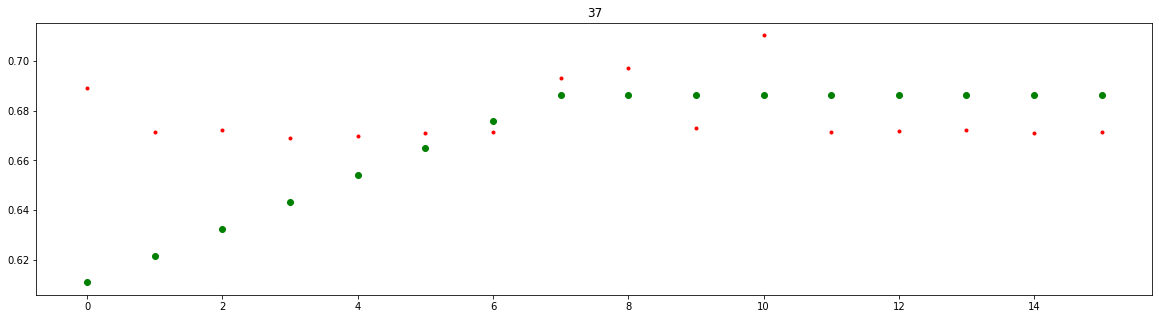

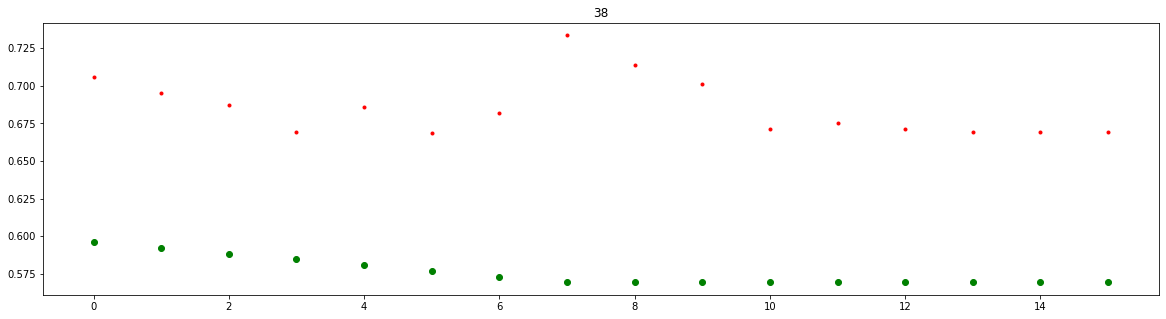

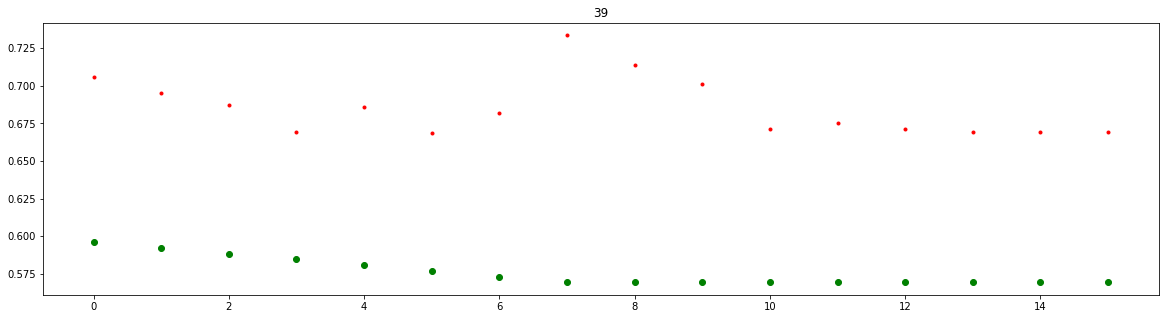

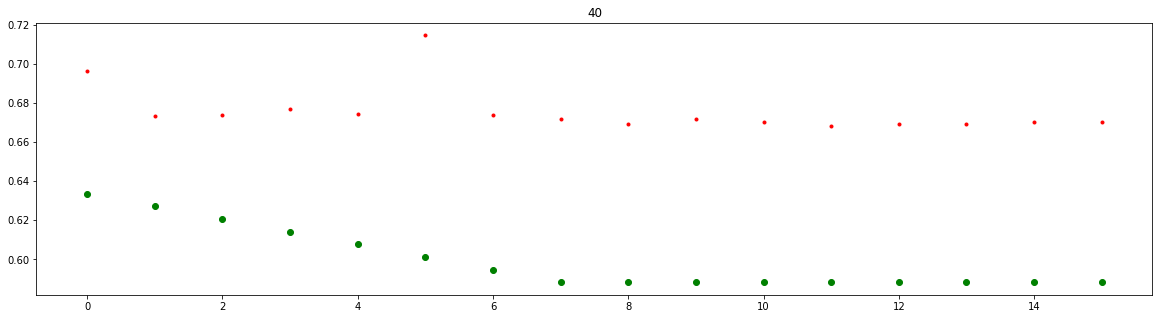

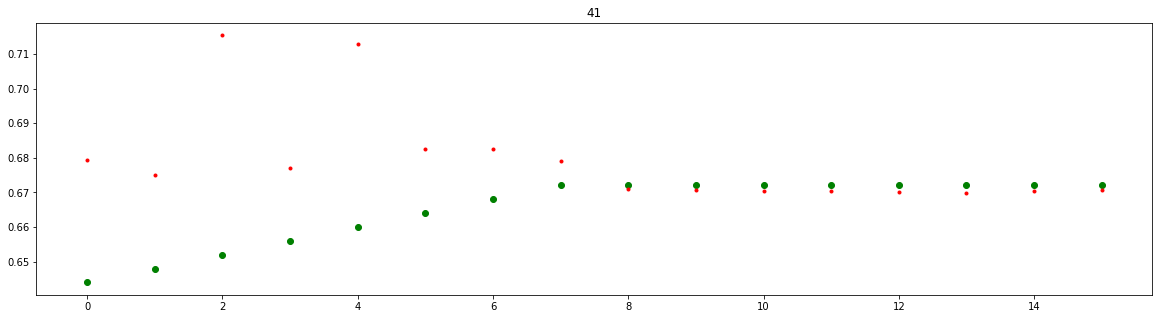

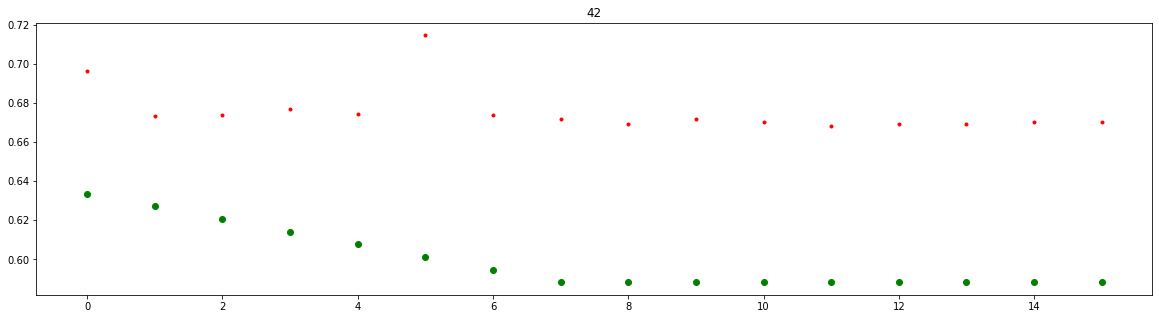

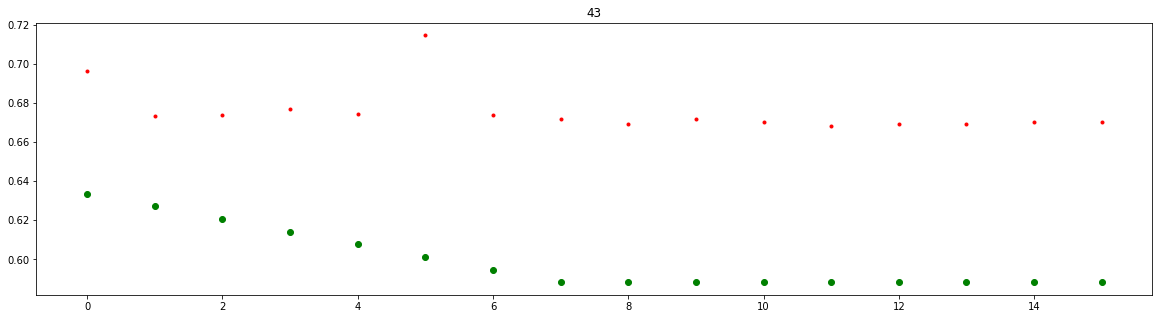

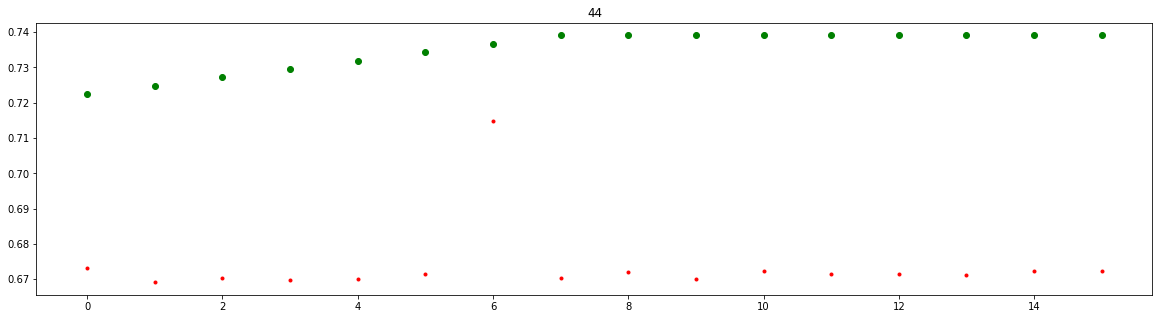

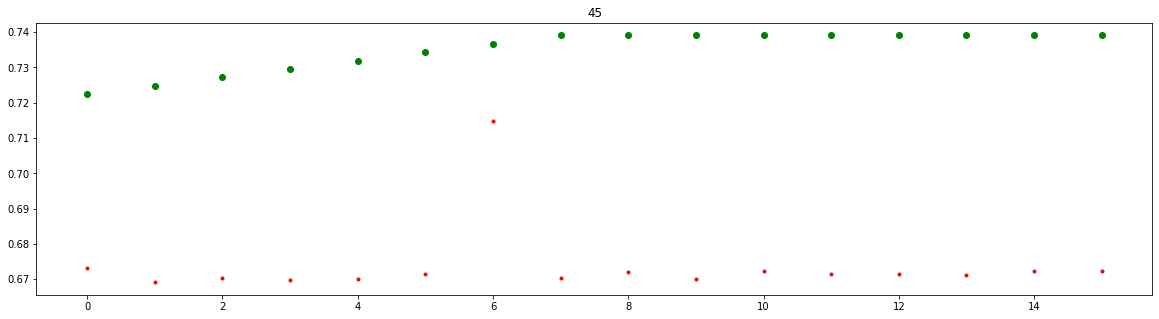

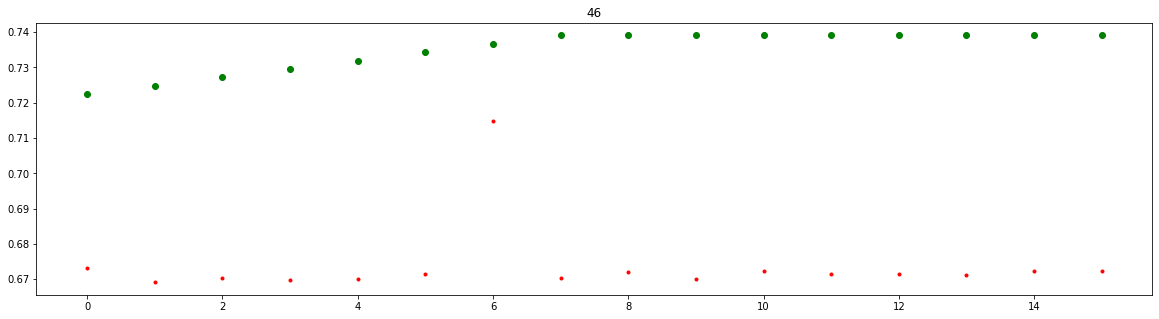

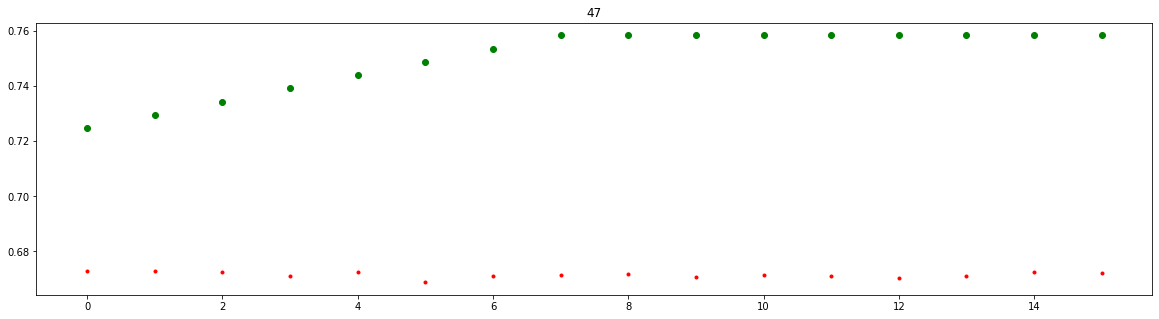

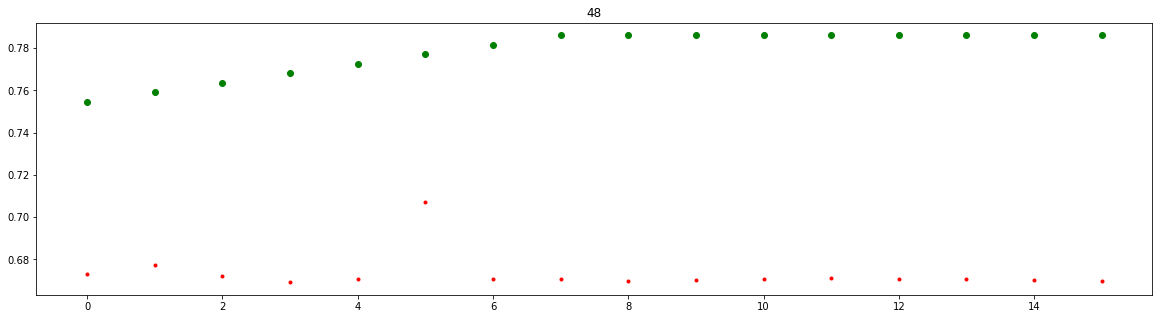

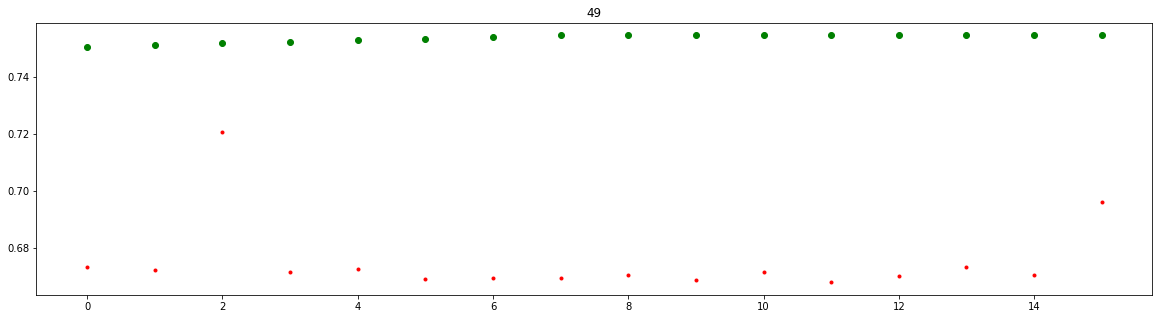

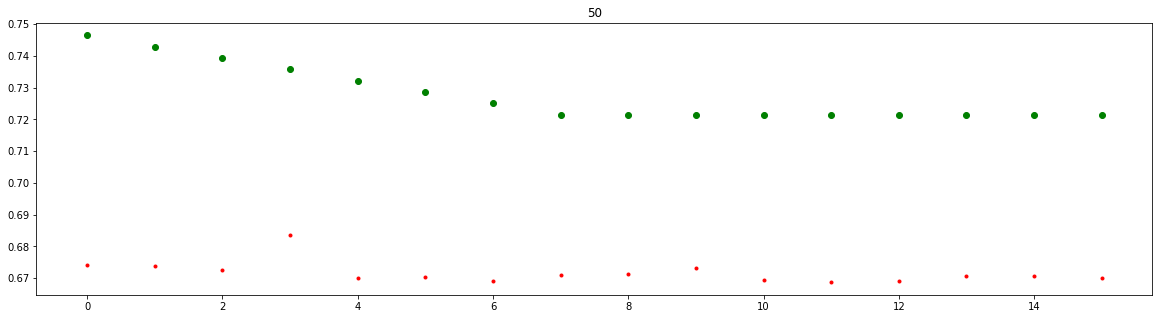

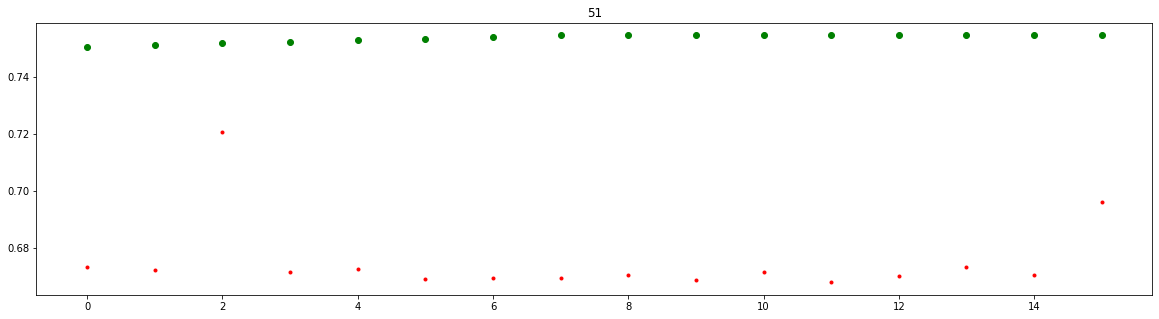

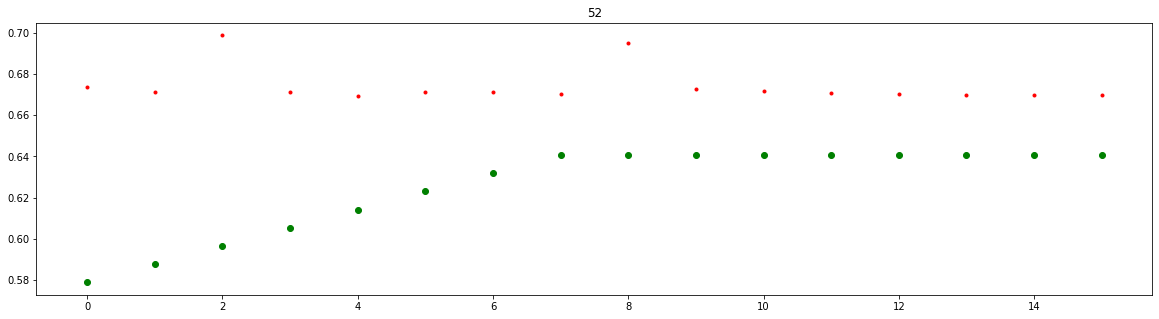

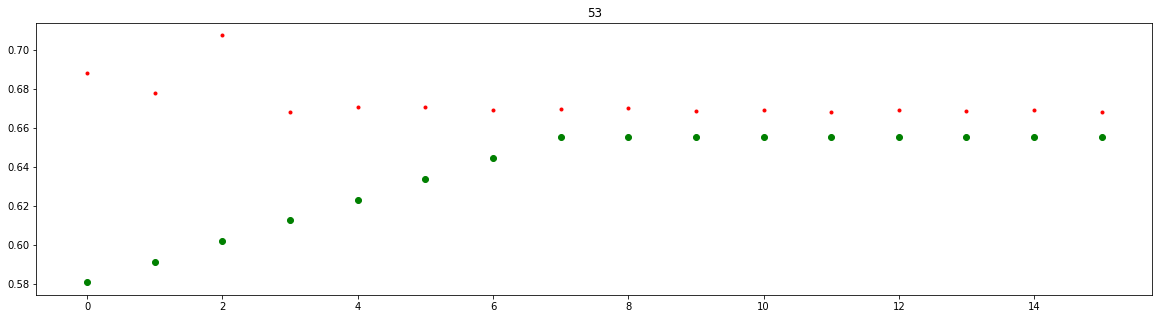

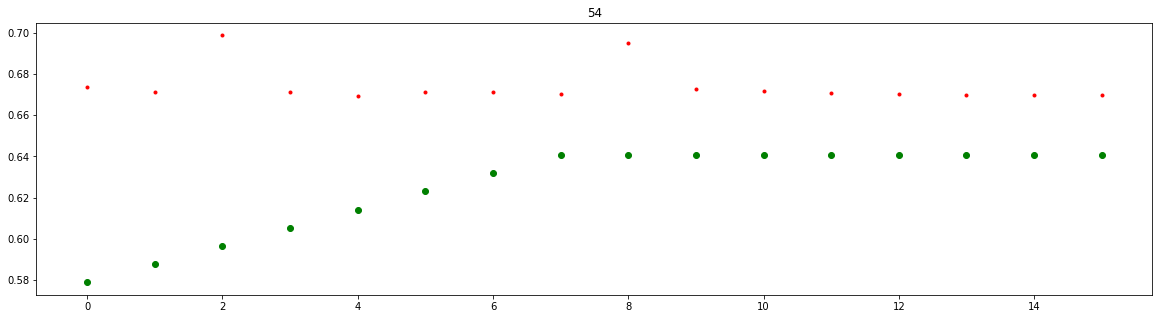

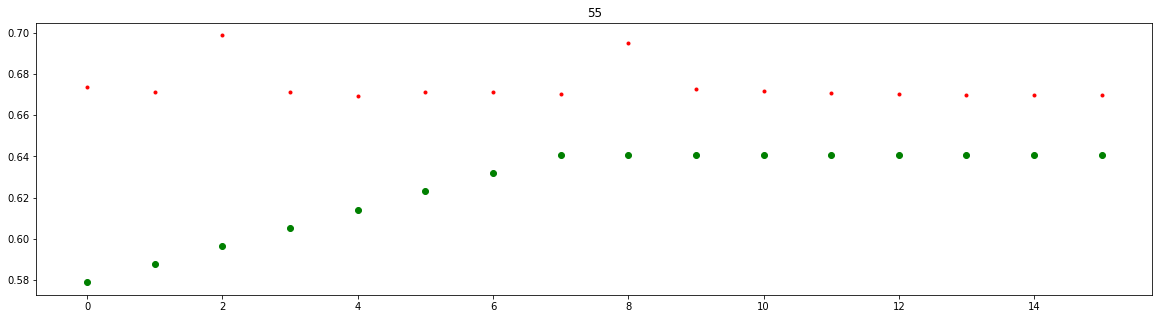

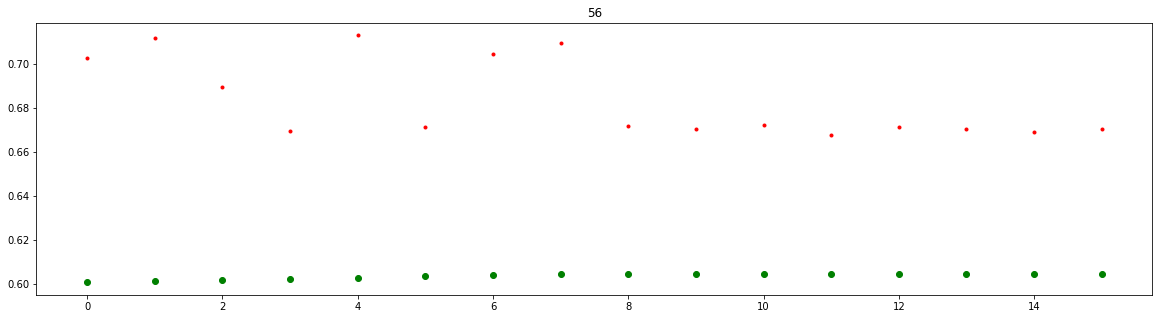

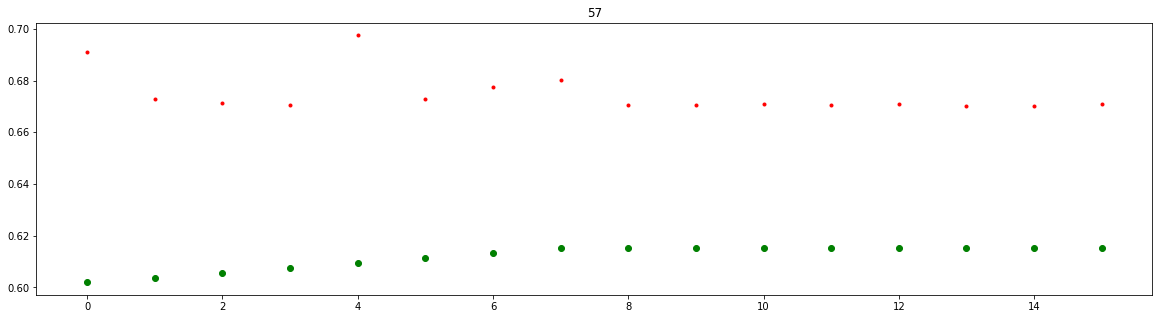

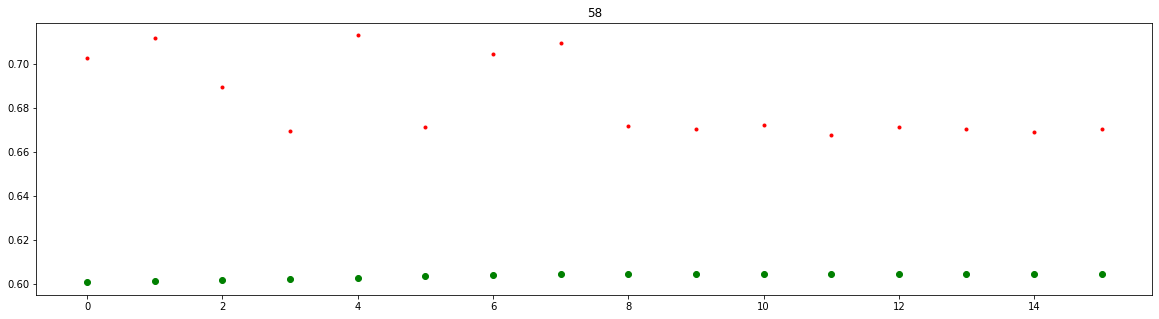

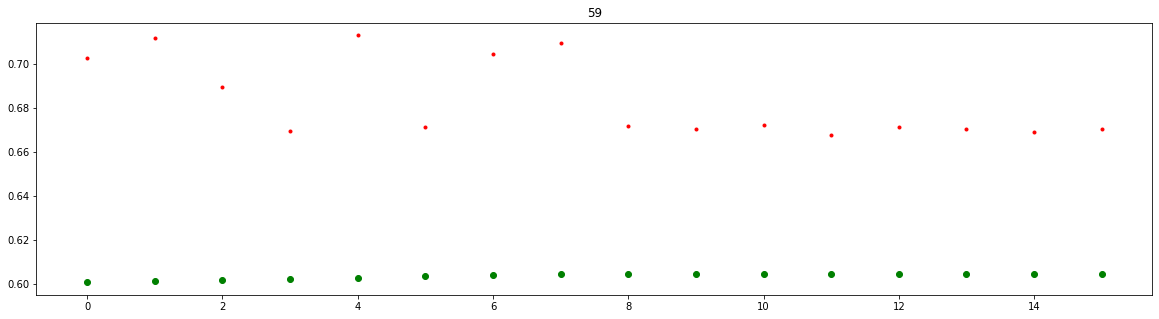

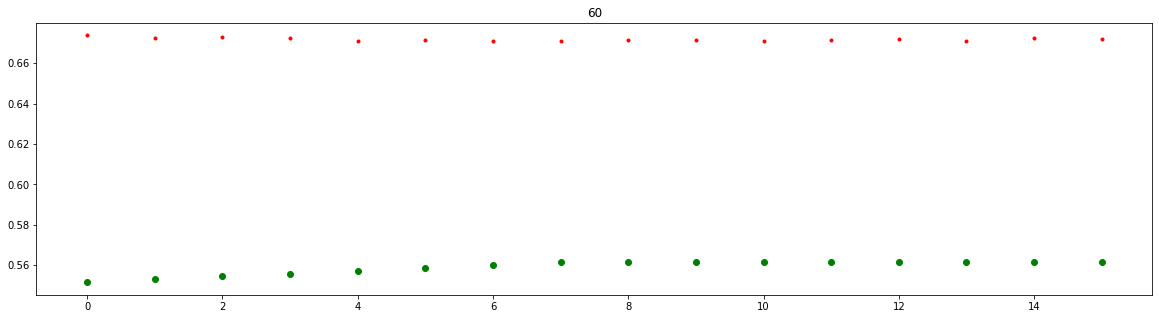

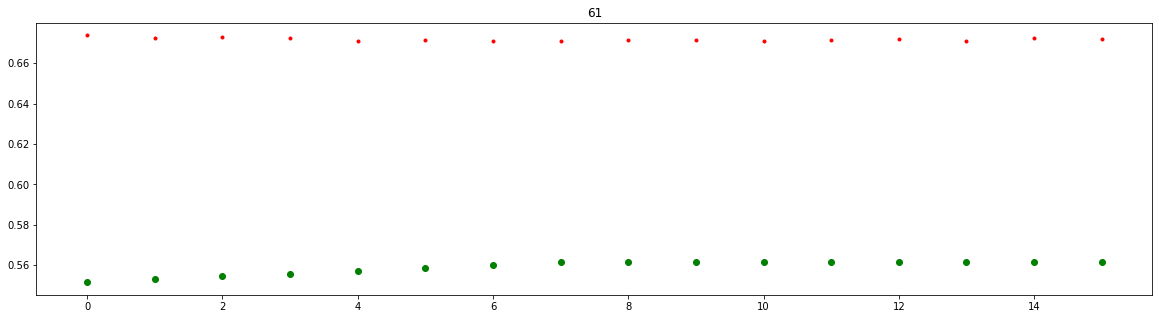

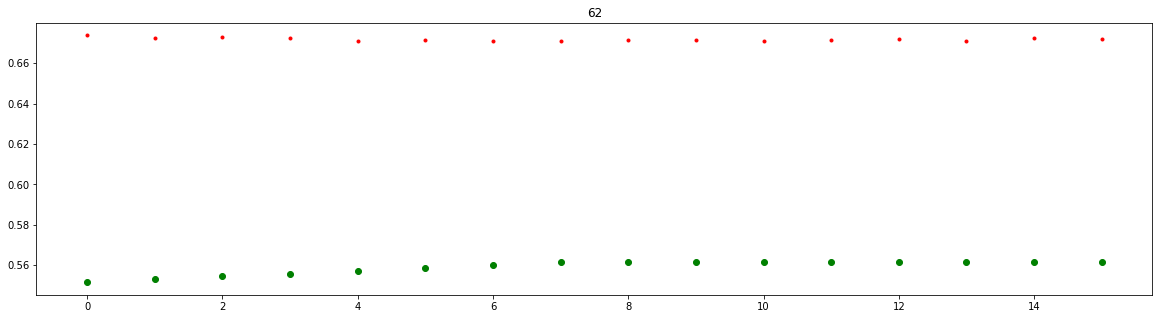

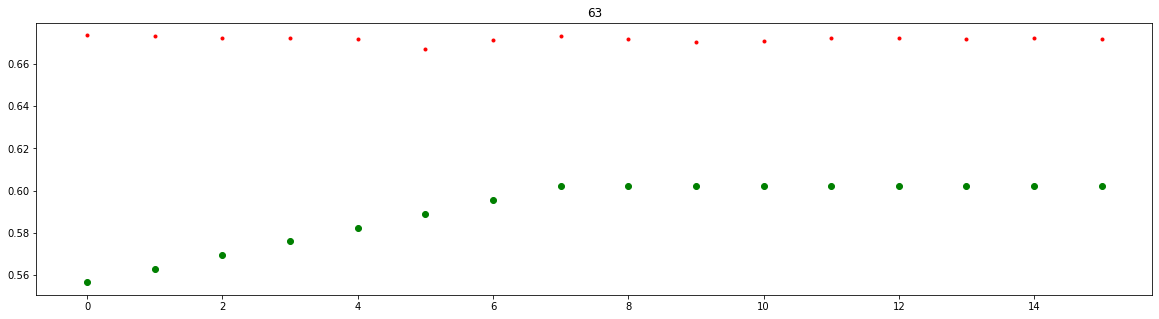

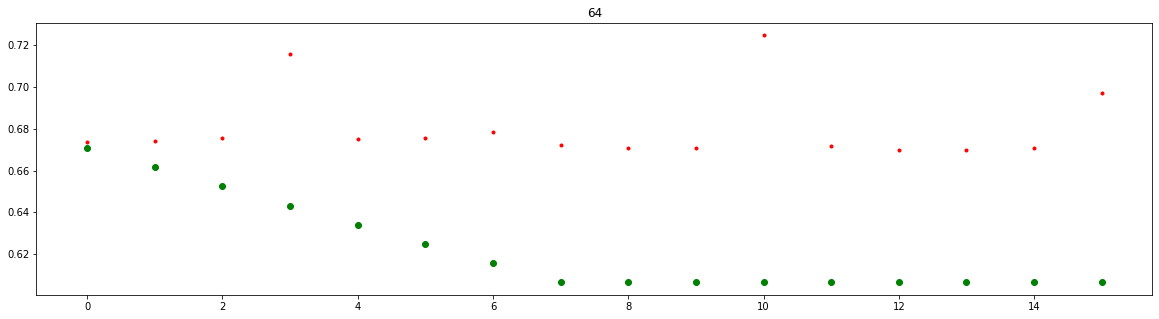

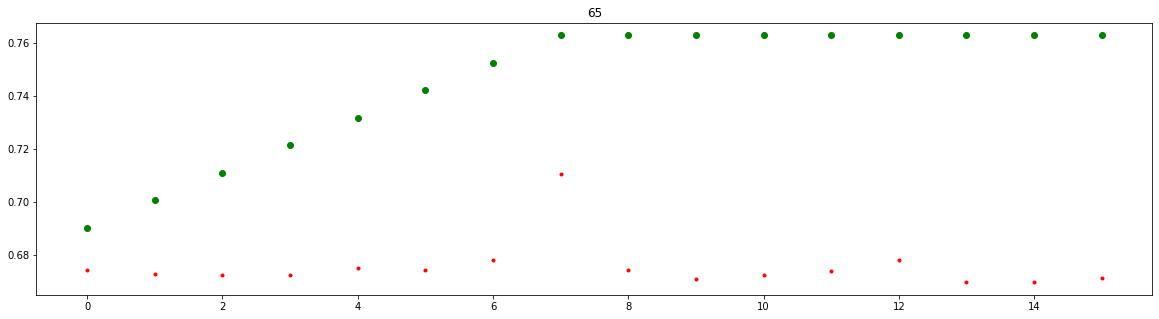

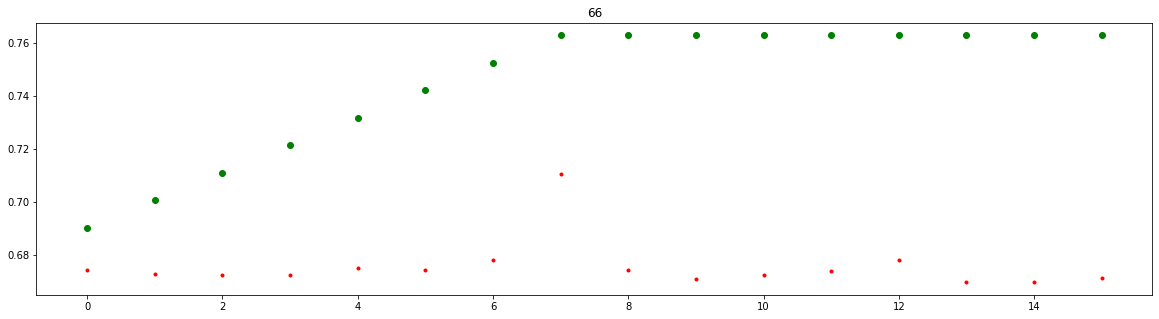

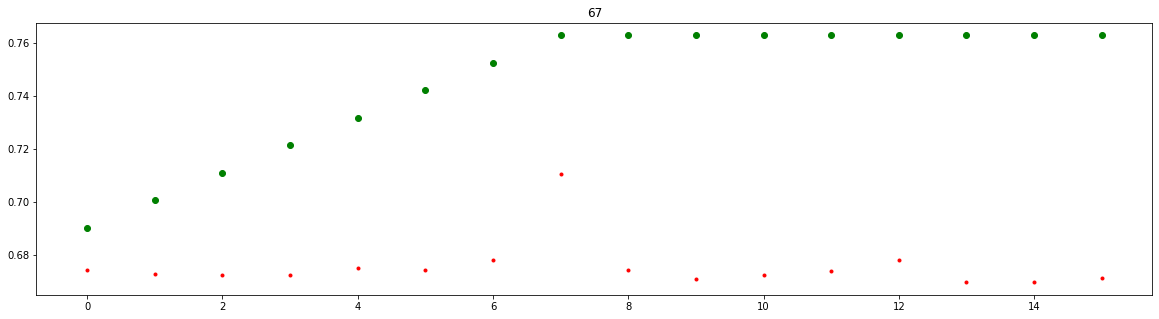

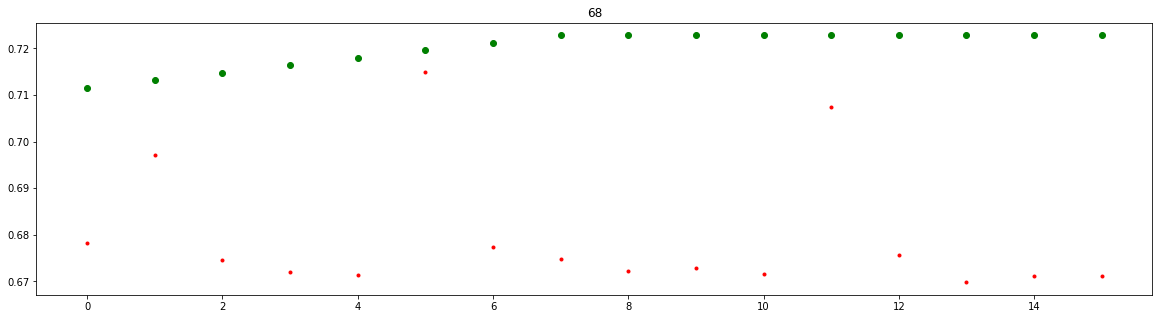

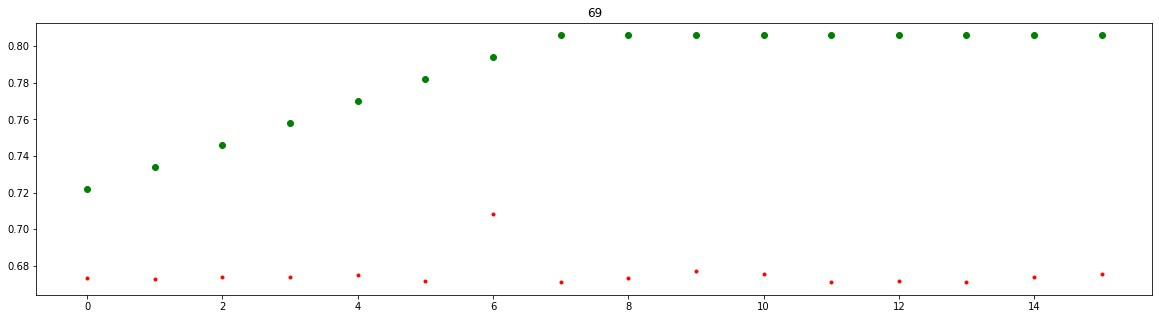

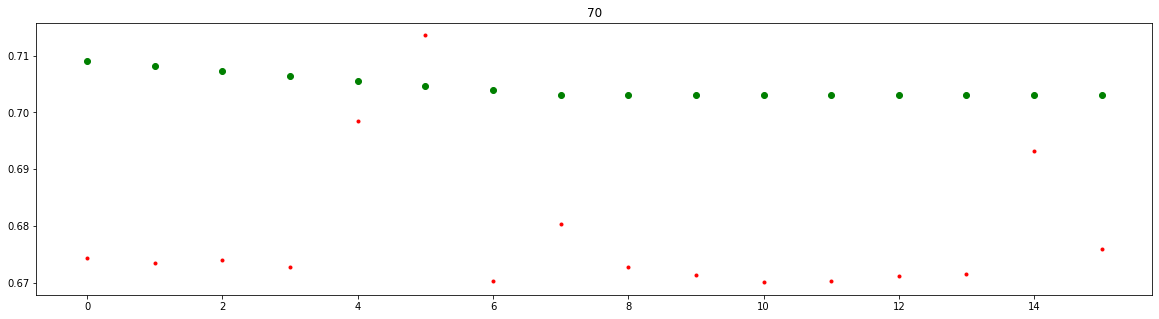

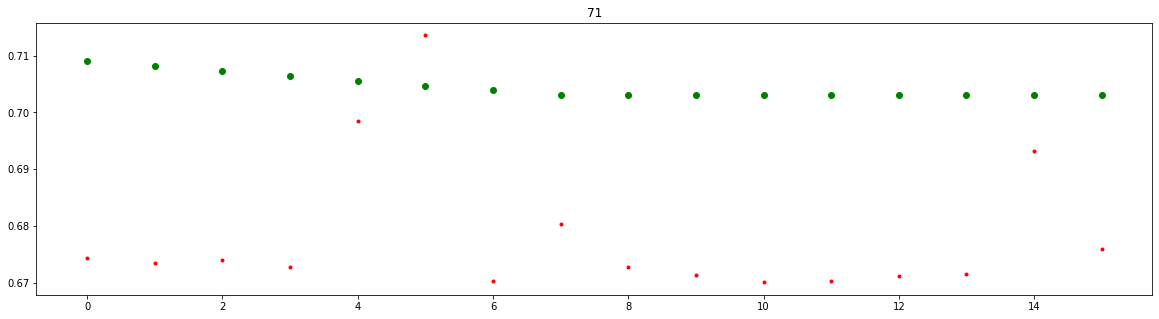

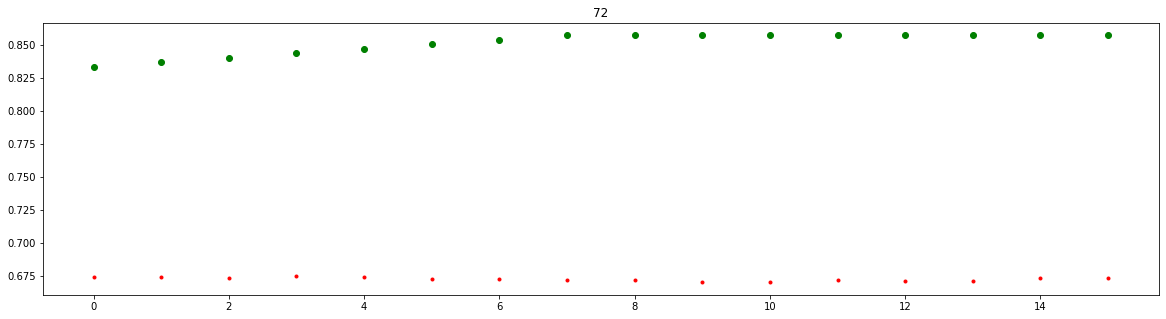

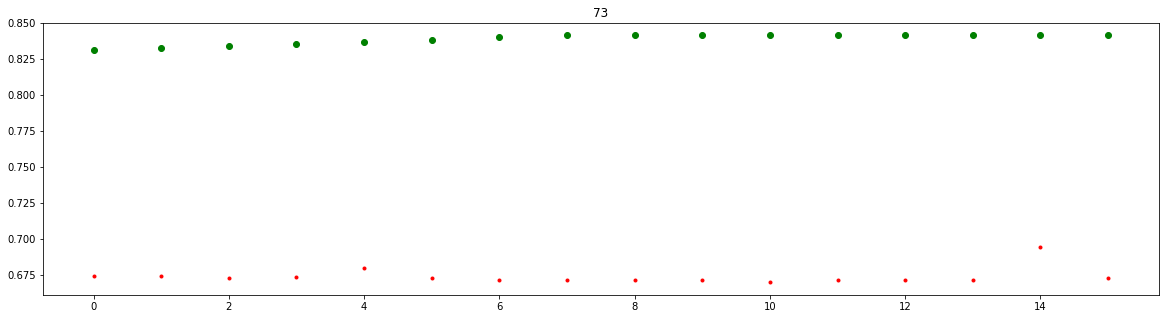

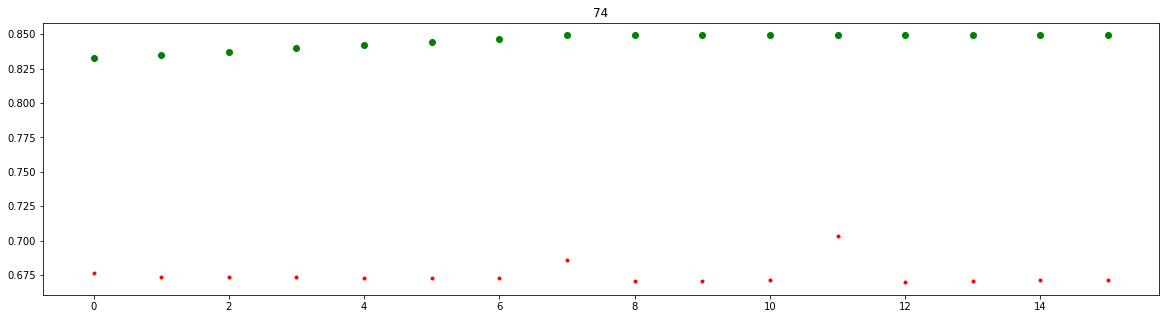

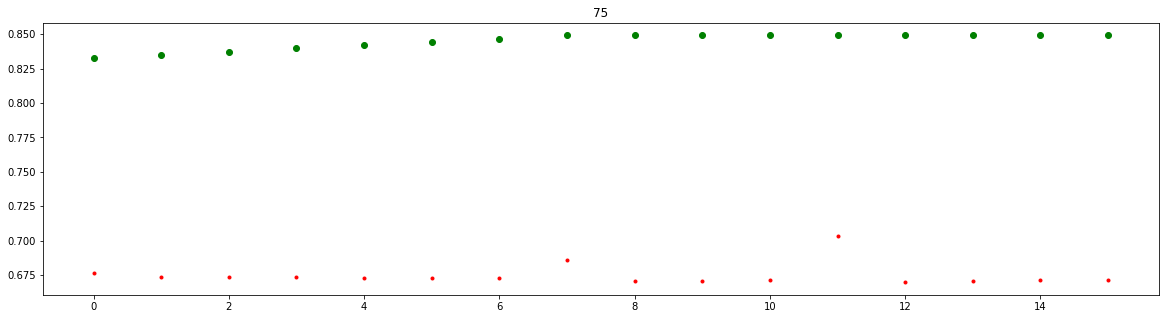

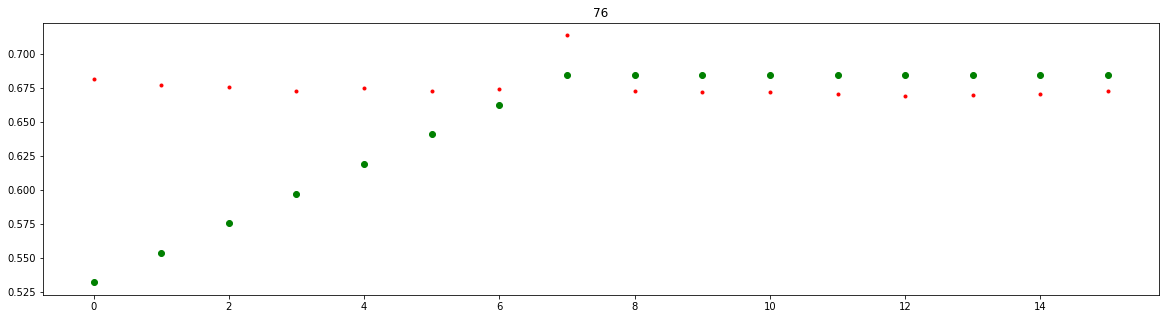

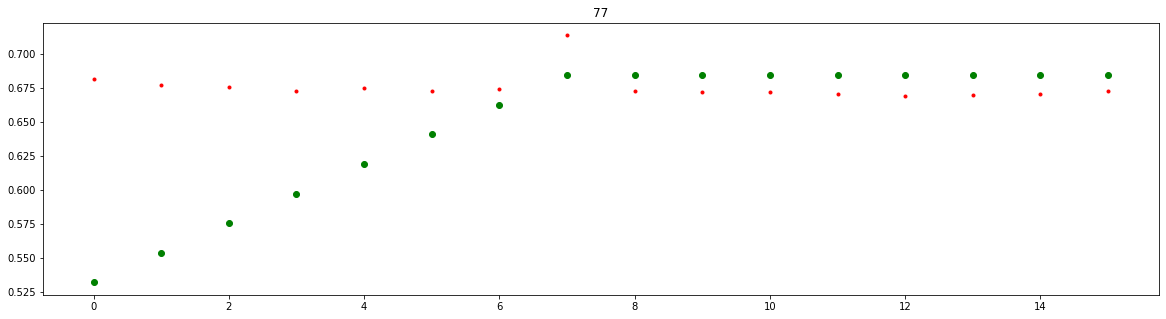

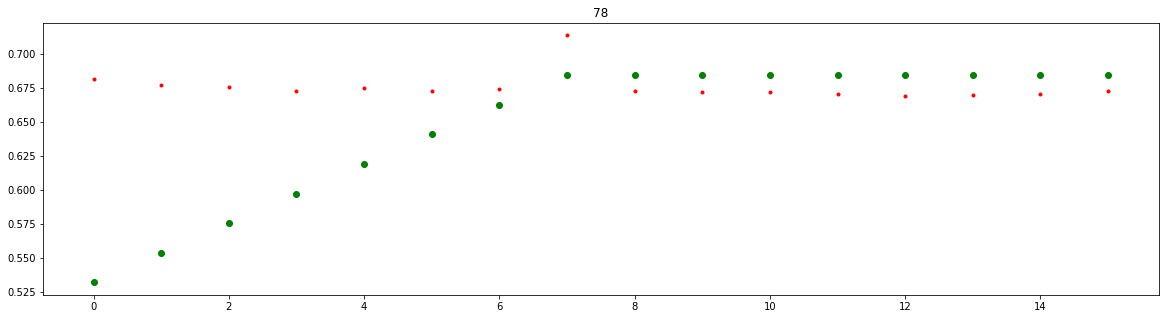

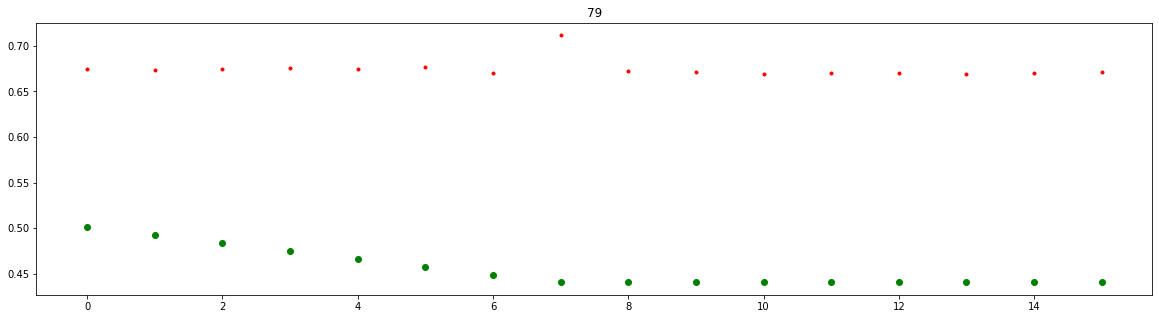

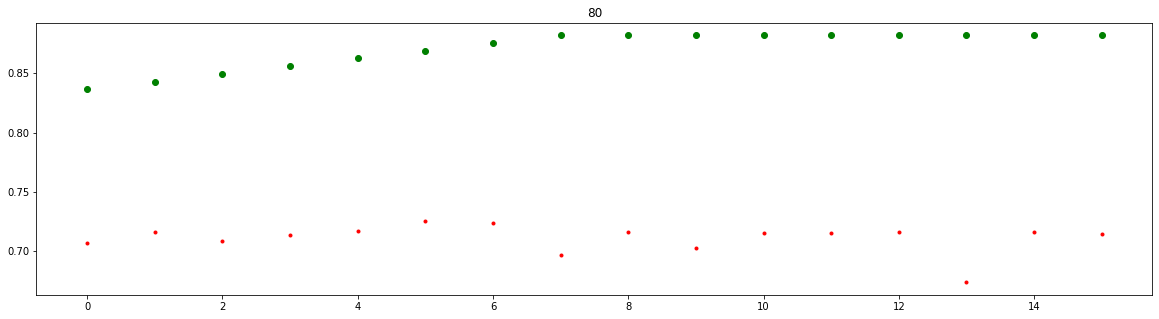

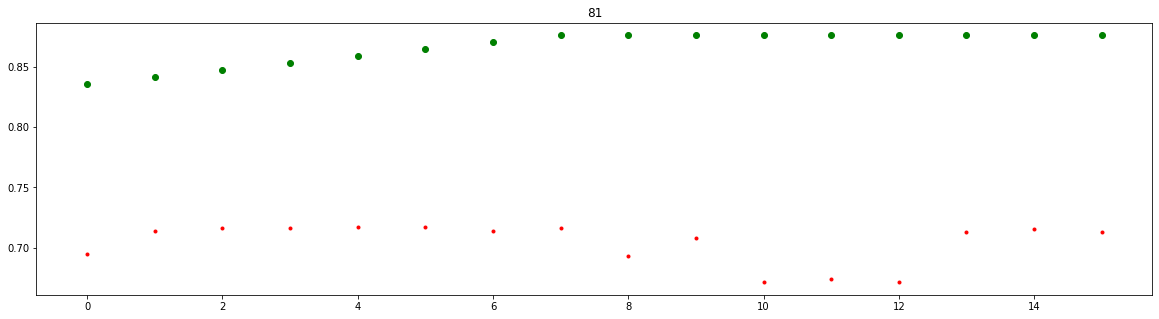

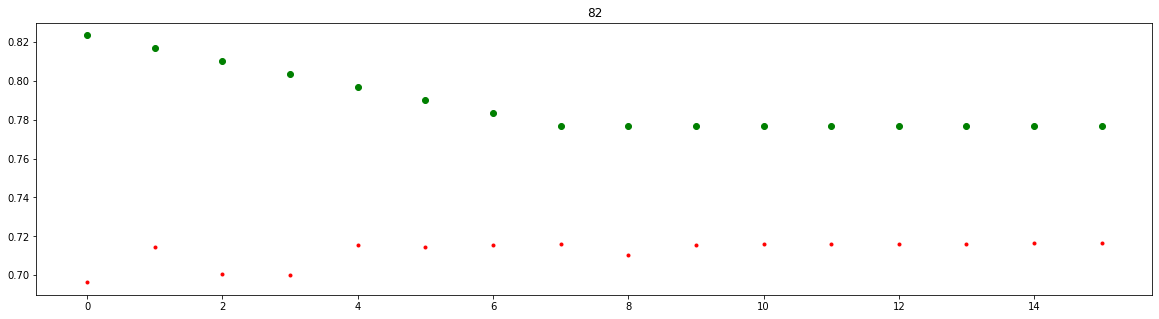

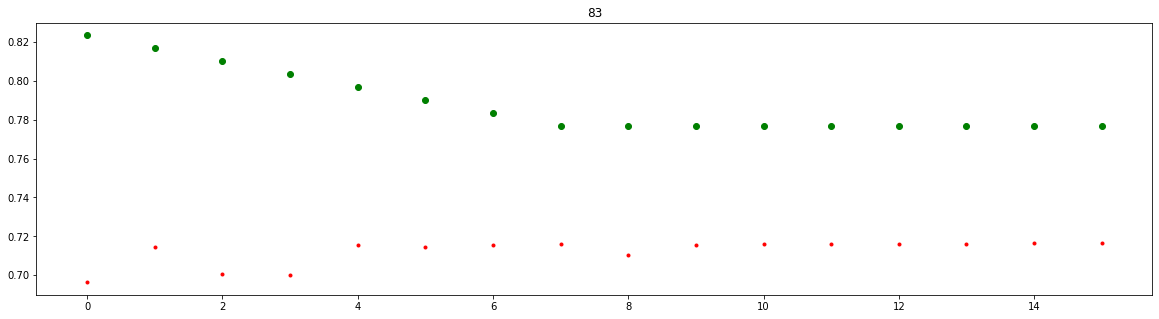

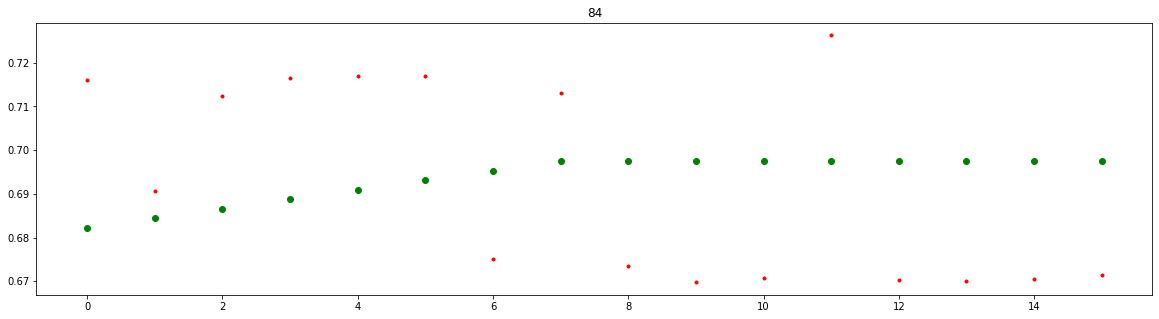

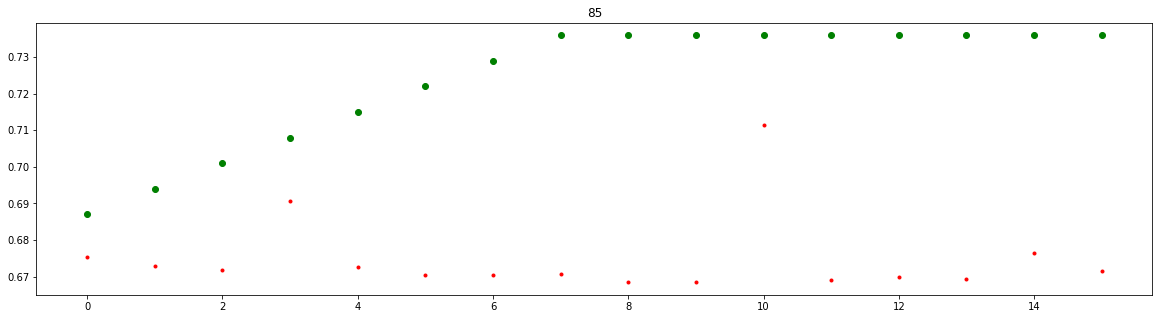

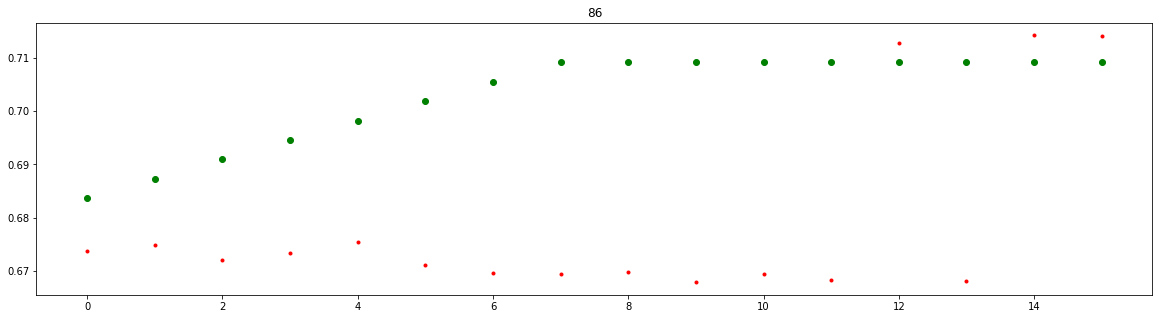

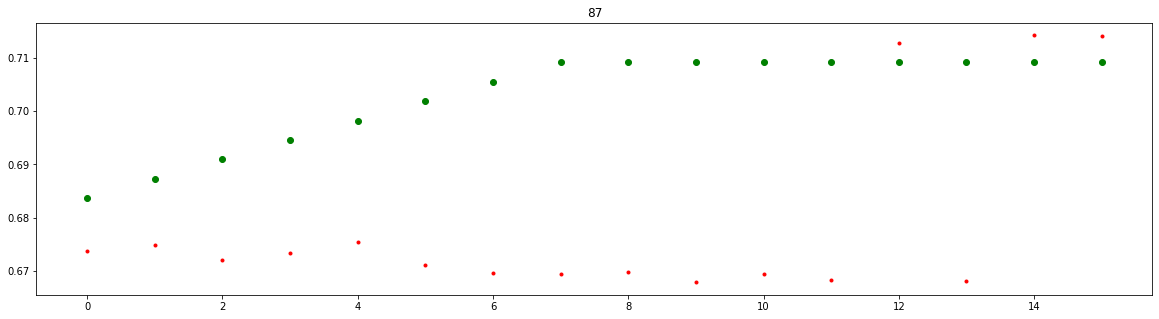

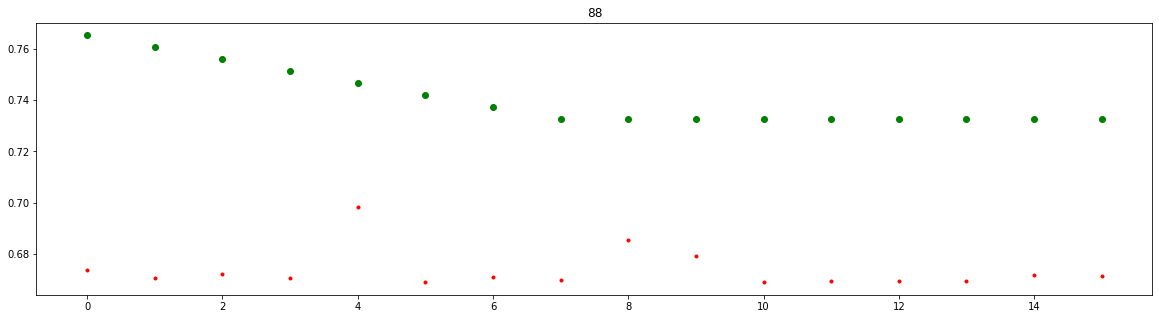

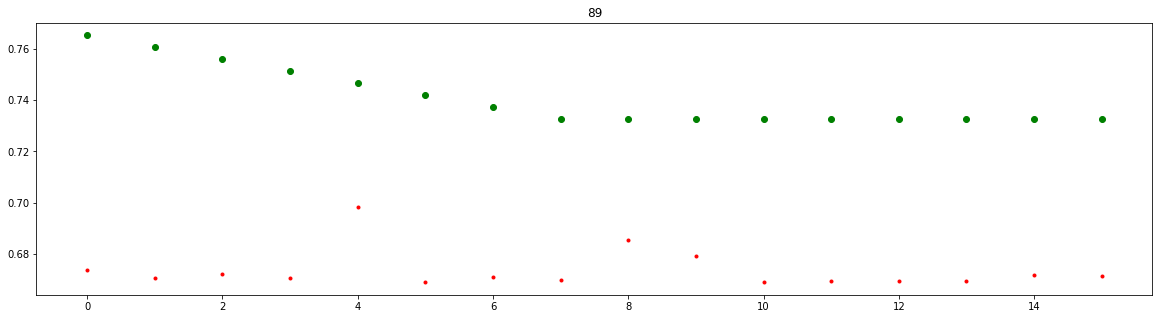

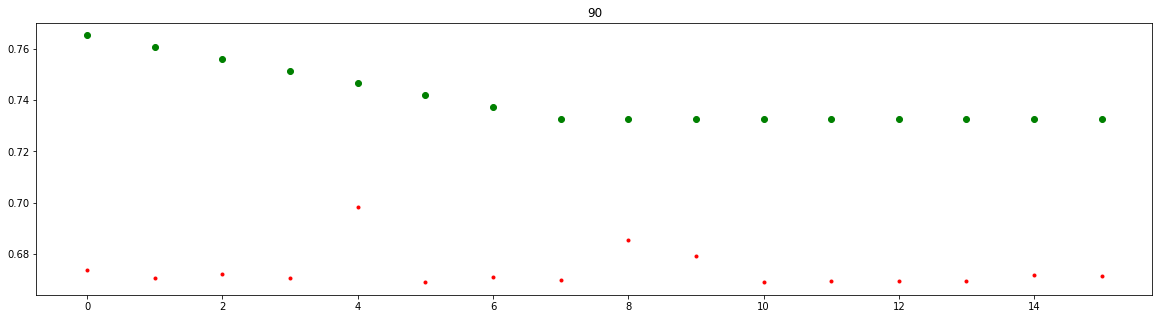

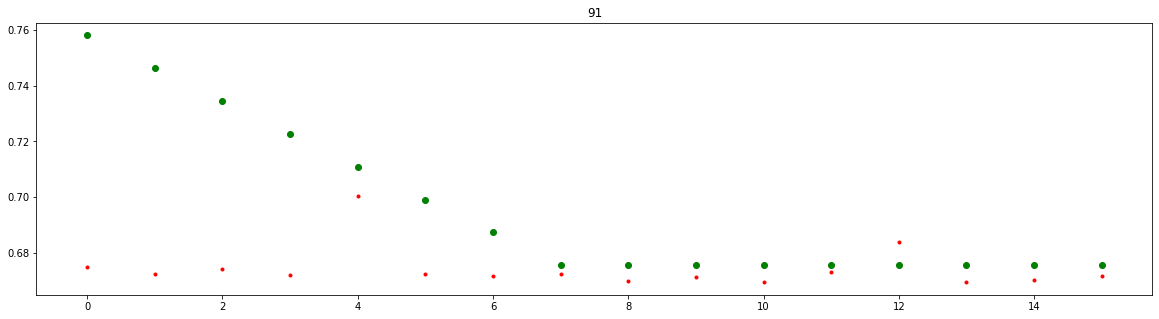

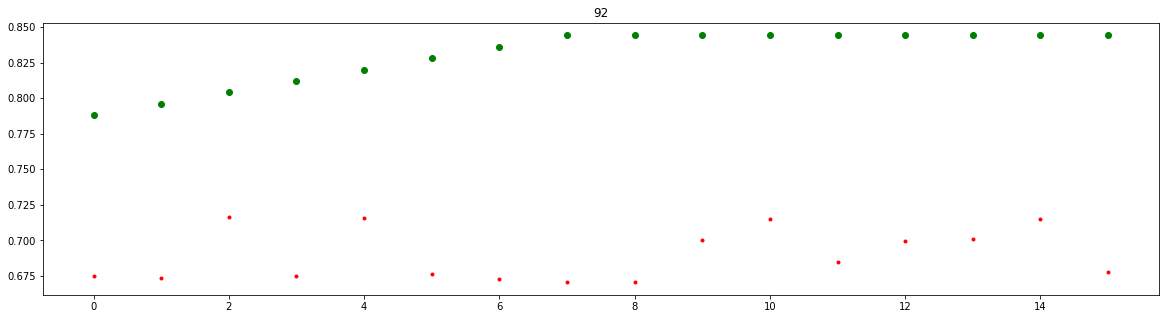

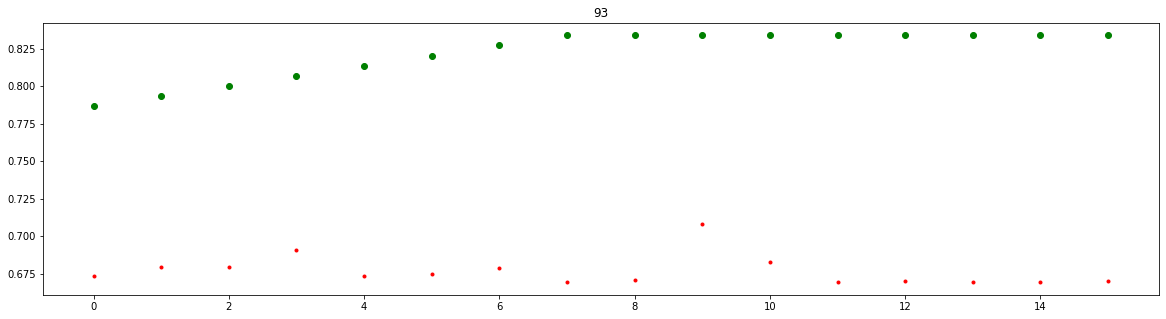

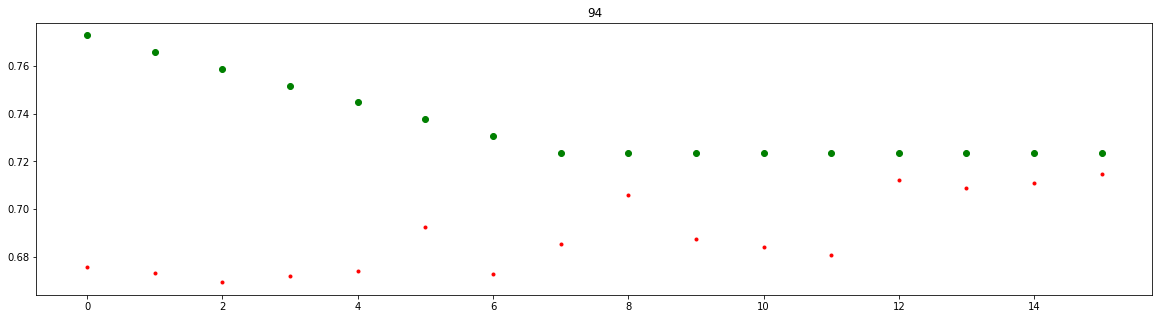

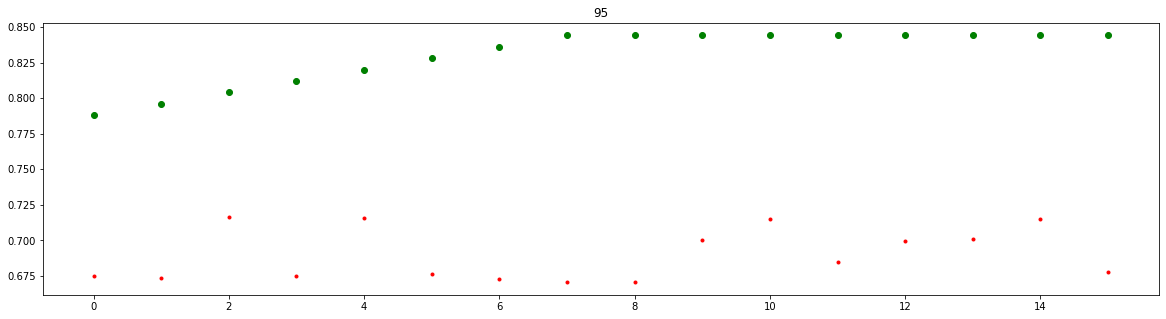

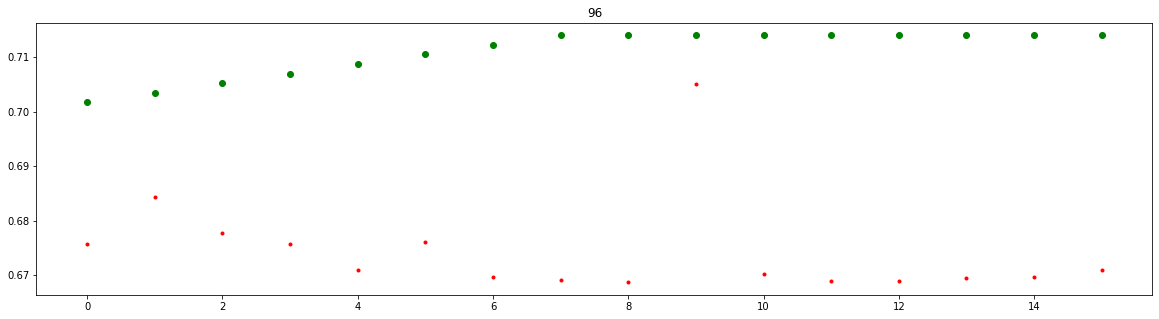

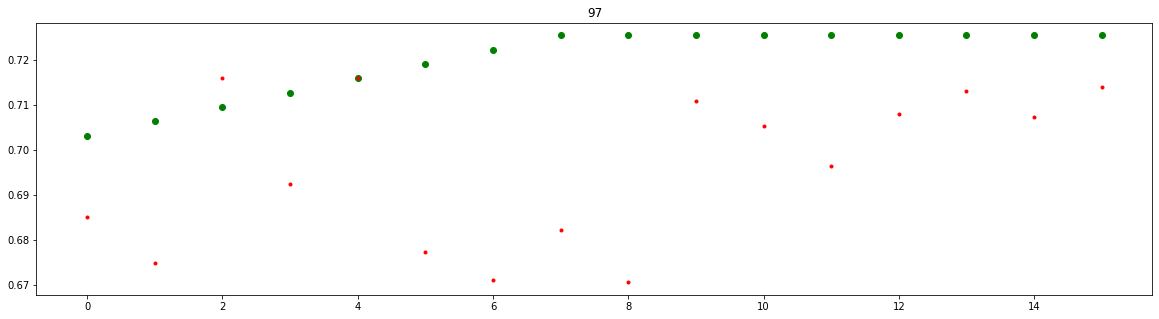

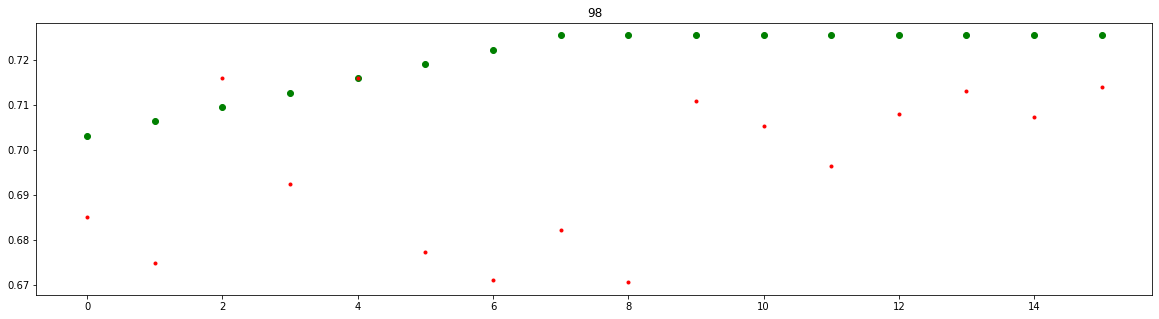

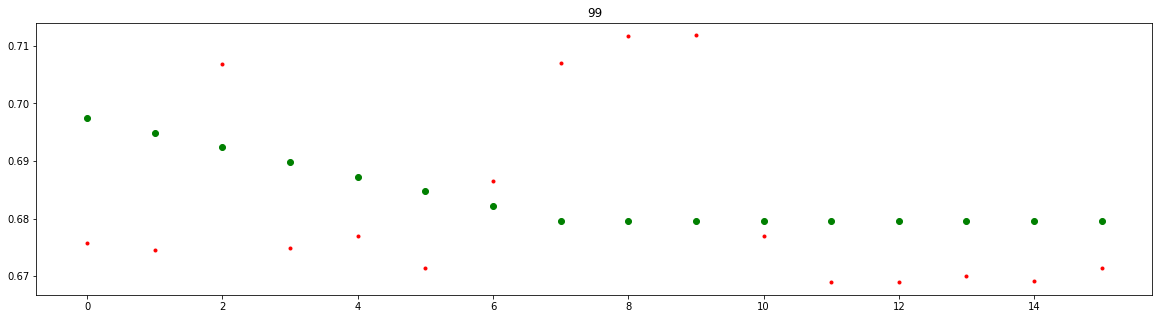

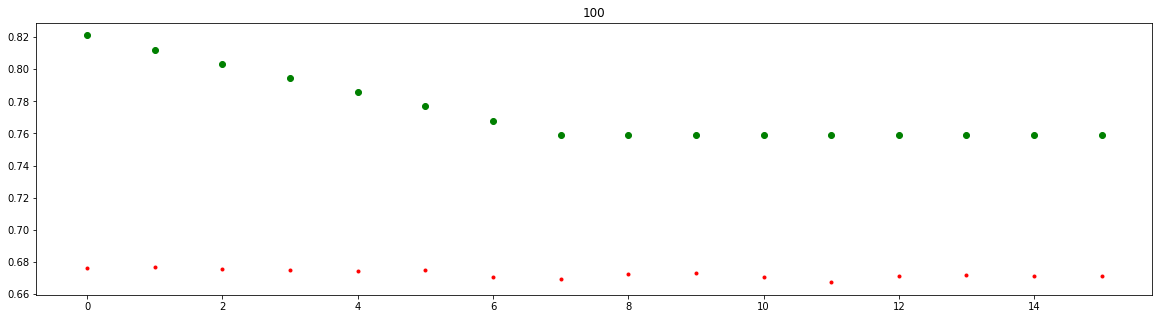

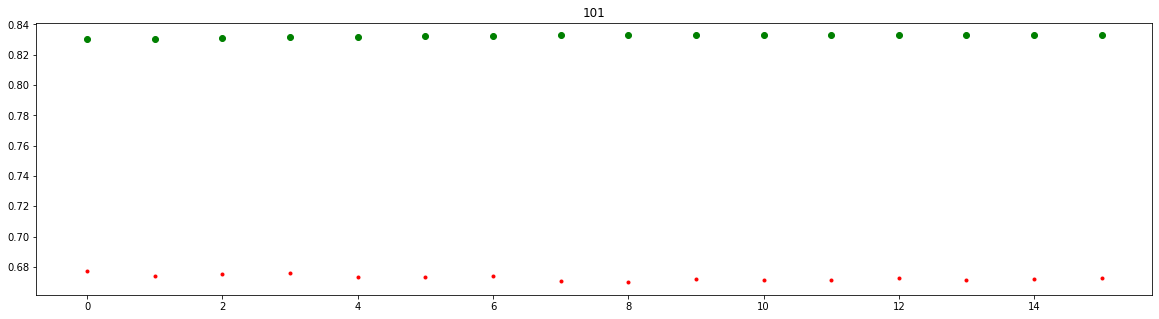

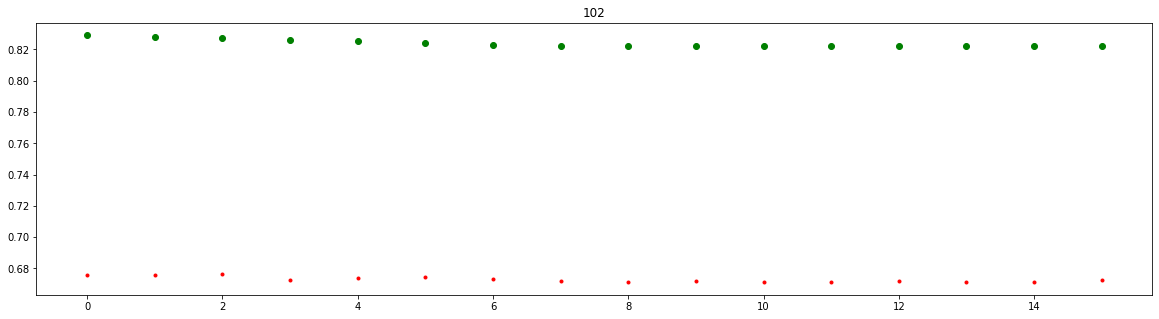

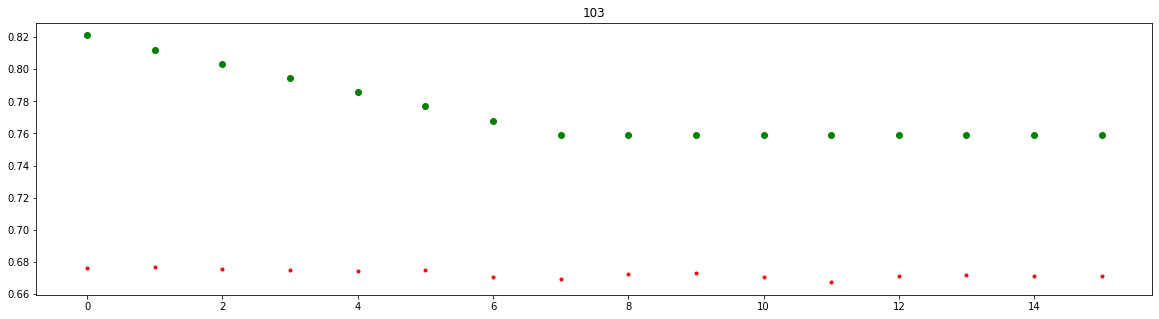

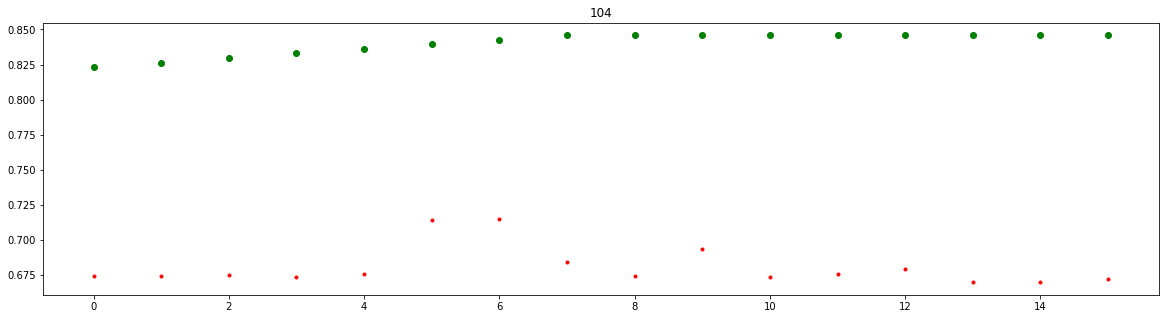

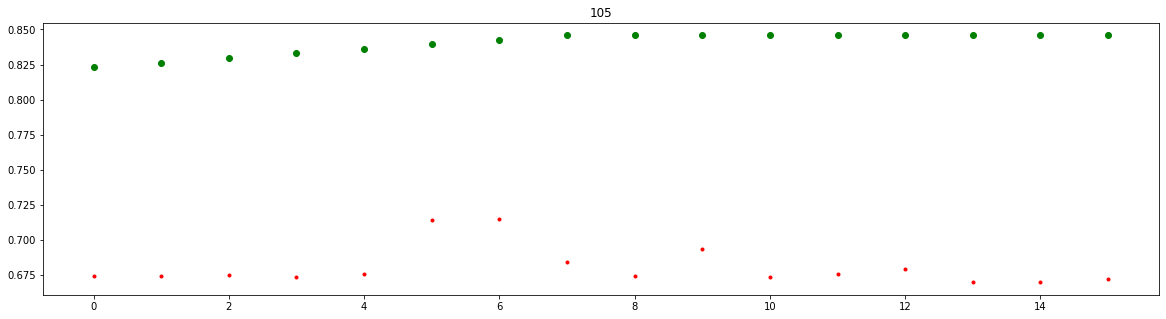

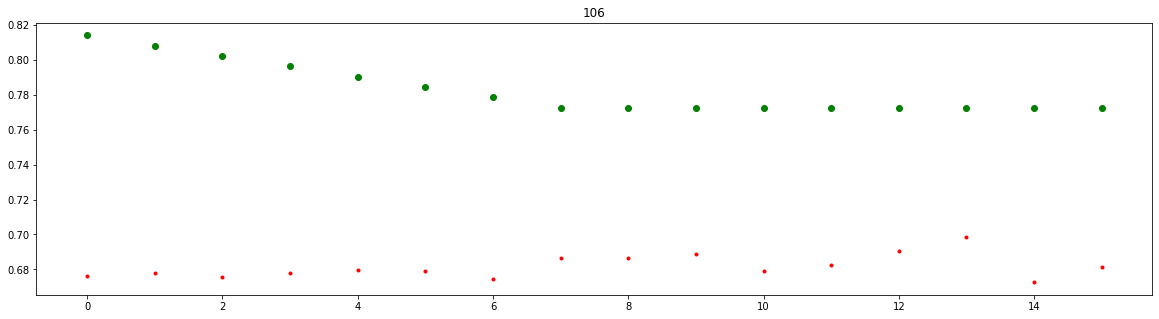

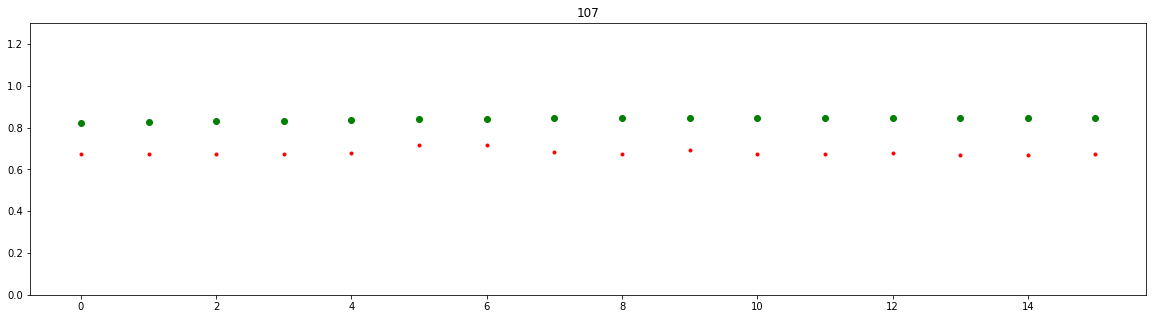

In [17]:
samples = [X for X in range(data['prediction'].shape[0])]

X = [X for X in range(0,5)]

# X = [X for X in range(data['encoder_target'][0:10])]

print(X)

X.append(len(X))

print(X)

files = [1,]

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5)) 
for sample in samples:
    # data = np.load(ifile)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5)) 
    
    Y = np.asarray(data['decoder_target'][sample][...]) 
    Y = 

    Y = np.asarray(data['decoder_target'][sample][...]) 
    Y_ = np.asarray(data['prediction'][sample,...,0]) 
    # print(county, Y)
    # print(Y_)
    X = [X for X in range(len(data['prediction'][sample,...,0]))]
    ax.plot(np.asarray(X), np.asarray(Y), 'o', color='green')
    ax.plot(np.asarray(X), np.asarray(Y_), '.', color='red')
    ax.set(title=sample)
plt.ylim([0, 1.3])
plt.show()

# for ifile in files:
#     # data = np.load(ifile)
    
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5)) 
#     for county in counties:
#         Y = np.asarray(data['decoder_target'][county][0]) 
#         Y_ = np.asarray(data['prediction'][county,0,0]) 
#         # print(county, Y)
#         # print(Y_)
#         ax.plot(np.asarray(county), np.asarray(Y), 'o', color='green')
#         ax.plot(np.asarray(county), np.asarray(Y_), '.', color='red')
#         ax.set(title=ifile)
#     plt.ylim([0, 1.3])
#     plt.show()

In [ ]:
fn

In [3]:
scrop = 'rice'

# MOD_BINS = 128
# FAM_BINS = 64

MOD_BINS = 512
FAM_BINS = 256

print( time.asctime( time.localtime(time.time()) ) )
alidata = pd.read_csv(f'data/ALIM{MOD_BINS}F{FAM_BINS}DATASET_{scrop}.csv')
print( 'DATASET loaded', time.asctime( time.localtime(time.time()) ) )

Wed Mar 15 09:34:58 2023
DATASET loaded Wed Mar 15 09:36:49 2023


In [4]:
display(alidata)

del alidata['Unnamed: 0']
# del alidata['Unnamed: 0.1']
# del alidata['Unnamed: 0.2']
# # del alidata['Unnamed: 0.1.1']
# del alidata['Unnamed: 0.1.1.1']

alidata['county']   = alidata['county'].astype(str)
alidata['year']     = alidata['year'].astype(str)
alidata['time_idx'] = alidata['time_idx'].astype(int)

print(type(alidata['county']), type(alidata['year']), type(alidata['time_idx'].max()))

yield_list = [f'{scrop}_sownarea', f'avg_{scrop}_sownarea', f'med_{scrop}_sownarea', \
              f'{scrop}_yieldval', f'avg_{scrop}_yieldval', f'med_{scrop}_yieldval', \
              f'{scrop}_yield', f'avg_{scrop}_yield', f'med_{scrop}_yield']

cols_to_move = yield_list
alidata = alidata[ [ col for col in alidata.columns if col not in cols_to_move ] + cols_to_move ]

# df_not_str = alidata.select_dtypes(include=float).astype("float32")
# df_str = alidata.select_dtypes(exclude=float)

# alidata = df_not_str.join(df_str)

alidata = alidata[ alidata['month'] < 11 ]

display(alidata)

,Unnamed: 0,time_idx,county,year,month,MOD_month_t,b0b0,b0b1,b0b2,b0b3,...,Wind_f_tavg_254,rice_sownarea,avg_rice_sownarea,med_rice_sownarea,rice_yieldval,avg_rice_yieldval,med_rice_yieldval,rice_yield,avg_rice_yield,med_rice_yield
0,0,0,0,2003,1,0,0.0,0.0,0.0,0.000000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,1.8012,0.84,0.74
1,1,1,0,2003,1,1,0.0,0.0,0.0,0.000000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,1.8012,0.84,0.74
2,2,2,0,2003,1,2,0.0,0.0,0.0,0.000000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,1.8012,0.84,0.74
3,3,3,0,2003,1,3,0.0,0.0,0.0,0.000000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,1.8012,0.84,0.74
4,4,4,0,2003,2,0,0.0,0.0,0.0,0.000000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,1.8012,0.84,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24160,24160,40,30,2022,11,3,0.0,0.0,0.0,1.505150,...,0.0,9999.90,75.13,74.54,9999999.9,62.83,65.31,1000.0100,0.83,0.87
24161,24161,41,30,2022,12,0,0.0,0.0,0.0,0.845098,...,0.0,9999.90,75.13,74.54,9999999.9,62.83,65.31,1000.0100,0.83,0.87
24162,24162,42,30,2022,12,1,0.0,0.0,0.0,1.602060,...,0.0,9999.90,75.13,74.54,9999999.9,62.83,65.31,1000.0100,0.83,0.87
24163,24163,43,30,2022,12,2,0.0,0.0,0.0,1.301030,...,0.0,9999.90,75.13,74.54,9999999.9,62.83,65.31,1000.0100,0.83,0.87


<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'numpy.int64'>


,time_idx,county,year,month,MOD_month_t,b0b0,b0b1,b0b2,b0b3,b0b4,...,Wind_f_tavg_254,rice_sownarea,avg_rice_sownarea,med_rice_sownarea,rice_yieldval,avg_rice_yieldval,med_rice_yieldval,rice_yield,avg_rice_yield,med_rice_yield
0,0,0,2003,1,0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,1.8012,0.84,0.74
1,1,0,2003,1,1,0.0,0.0,0.0,0.00000,0.000000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,1.8012,0.84,0.74
2,2,0,2003,1,2,0.0,0.0,0.0,0.00000,0.000000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,1.8012,0.84,0.74
3,3,0,2003,1,3,0.0,0.0,0.0,0.00000,0.000000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,1.8012,0.84,0.74
4,4,0,2003,2,0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,1.8012,0.84,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24152,32,30,2022,9,1,0.0,0.0,0.0,0.00000,0.000000,...,0.0,9999.90,75.13,74.54,9999999.9,62.83,65.31,1000.0100,0.83,0.87
24153,33,30,2022,9,2,0.0,0.0,0.0,0.00000,0.477121,...,0.0,9999.90,75.13,74.54,9999999.9,62.83,65.31,1000.0100,0.83,0.87
24154,34,30,2022,10,0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,9999.90,75.13,74.54,9999999.9,62.83,65.31,1000.0100,0.83,0.87
24155,35,30,2022,10,1,0.0,0.0,0.0,0.00000,0.000000,...,0.0,9999.90,75.13,74.54,9999999.9,62.83,65.31,1000.0100,0.83,0.87


In [5]:
# aliv = alidata[ alidata['year'] == '2004']
# alio = alidata[ alidata['year'] == '2003']

# months = alidata['month'].unique()

# for month in months:
#     display(aliv[ aliv['month'] == month ])
#     display(alio[ alio['month'] == month ])
               
# fn

In [6]:
infer_mask = alidata['year'].isin(['2019', '2020', '2021', '2022'])

data_infer = alidata[infer_mask]

data_infer['rice_sownarea'] = np.nan
data_infer['rice_yieldval'] = np.nan
data_infer['rice_yield']    = np.nan

years = [str(x) for x in range(2003, 2019)]

val_year = str(2004)

years.remove(val_year)

train_mask = alidata['year'].isin(years)
data = alidata[train_mask]

val_mask = alidata['year'].isin([val_year])
data_val = alidata[val_mask]

display(data_infer)

display(data)

display(data_val)

data_inference = pd.concat([data_val, data_infer], axis=0)

display(data_inference)

print(len(data['county'].unique()), len(data['year'].unique()))

# fn


/tmp/ipykernel_448489/1013611134.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_infer['rice_sownarea'] = np.nan
/tmp/ipykernel_448489/1013611134.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_infer['rice_yieldval'] = np.nan
/tmp/ipykernel_448489/1013611134.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,time_idx,county,year,month,MOD_month_t,b0b0,b0b1,b0b2,b0b3,b0b4,...,Wind_f_tavg_254,rice_sownarea,avg_rice_sownarea,med_rice_sownarea,rice_yieldval,avg_rice_yieldval,med_rice_yieldval,rice_yield,avg_rice_yield,med_rice_yield
716,0,0,2019,1,0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,NaN,0.84,0.74
717,1,0,2019,1,1,0.0,0.0,0.0,0.00000,0.000000,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,NaN,0.84,0.74
718,2,0,2019,1,2,0.0,0.0,0.0,0.00000,0.000000,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,NaN,0.84,0.74
719,3,0,2019,1,3,0.0,0.0,0.0,0.00000,0.000000,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,NaN,0.84,0.74
720,4,0,2019,2,0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,NaN,0.84,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24152,32,30,2022,9,1,0.0,0.0,0.0,0.00000,0.000000,...,0.0,NaN,75.13,74.54,NaN,62.83,65.31,NaN,0.83,0.87
24153,33,30,2022,9,2,0.0,0.0,0.0,0.00000,0.477121,...,0.0,NaN,75.13,74.54,NaN,62.83,65.31,NaN,0.83,0.87
24154,34,30,2022,10,0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,NaN,75.13,74.54,NaN,62.83,65.31,NaN,0.83,0.87
24155,35,30,2022,10,1,0.0,0.0,0.0,0.00000,0.000000,...,0.0,NaN,75.13,74.54,NaN,62.83,65.31,NaN,0.83,0.87


,time_idx,county,year,month,MOD_month_t,b0b0,b0b1,b0b2,b0b3,b0b4,...,Wind_f_tavg_254,rice_sownarea,avg_rice_sownarea,med_rice_sownarea,rice_yieldval,avg_rice_yieldval,med_rice_yieldval,rice_yield,avg_rice_yield,med_rice_yield
0,0,0,2003,1,0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,1.61,0.44,0.26,2.90,0.45,0.22,1.8012,0.84,0.74
1,1,0,2003,1,1,0.0,0.0,0.0,0.000000,0.000000,...,0.0,1.61,0.44,0.26,2.90,0.45,0.22,1.8012,0.84,0.74
2,2,0,2003,1,2,0.0,0.0,0.0,0.000000,0.000000,...,0.0,1.61,0.44,0.26,2.90,0.45,0.22,1.8012,0.84,0.74
3,3,0,2003,1,3,0.0,0.0,0.0,0.000000,0.000000,...,0.0,1.61,0.44,0.26,2.90,0.45,0.22,1.8012,0.84,0.74
4,4,0,2003,2,0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,1.61,0.44,0.26,2.90,0.45,0.22,1.8012,0.84,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23973,32,30,2018,9,1,0.0,0.0,0.0,0.477121,0.477121,...,0.0,78.39,75.13,74.54,72.65,62.83,65.31,0.9268,0.83,0.87
23974,33,30,2018,9,2,0.0,0.0,0.0,0.000000,0.000000,...,0.0,78.39,75.13,74.54,72.65,62.83,65.31,0.9268,0.83,0.87
23975,34,30,2018,10,0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,78.39,75.13,74.54,72.65,62.83,65.31,0.9268,0.83,0.87
23976,35,30,2018,10,1,0.0,0.0,0.0,0.602060,0.000000,...,0.0,78.39,75.13,74.54,72.65,62.83,65.31,0.9268,0.83,0.87


,time_idx,county,year,month,MOD_month_t,b0b0,b0b1,b0b2,b0b3,b0b4,...,Wind_f_tavg_254,rice_sownarea,avg_rice_sownarea,med_rice_sownarea,rice_yieldval,avg_rice_yieldval,med_rice_yieldval,rice_yield,avg_rice_yield,med_rice_yield
45,0,0,2004,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,1.2317,0.84,0.74
46,1,0,2004,1,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,1.2317,0.84,0.74
47,2,0,2004,1,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,1.2317,0.84,0.74
48,3,0,2004,1,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,1.2317,0.84,0.74
49,4,0,2004,2,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,1.2317,0.84,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23347,32,30,2004,9,2,0.0,0.0,0.0,0.0,0.0,...,0.0,66.77,75.13,74.54,39.31,62.83,65.31,0.5887,0.83,0.87
23348,33,30,2004,9,3,0.0,0.0,0.0,0.0,0.0,...,0.0,66.77,75.13,74.54,39.31,62.83,65.31,0.5887,0.83,0.87
23349,34,30,2004,10,0,0.0,0.0,0.0,0.0,0.0,...,0.0,66.77,75.13,74.54,39.31,62.83,65.31,0.5887,0.83,0.87
23350,35,30,2004,10,1,0.0,0.0,0.0,0.0,0.0,...,0.0,66.77,75.13,74.54,39.31,62.83,65.31,0.5887,0.83,0.87


,time_idx,county,year,month,MOD_month_t,b0b0,b0b1,b0b2,b0b3,b0b4,...,Wind_f_tavg_254,rice_sownarea,avg_rice_sownarea,med_rice_sownarea,rice_yieldval,avg_rice_yieldval,med_rice_yieldval,rice_yield,avg_rice_yield,med_rice_yield
45,0,0,2004,1,0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,1.2317,0.84,0.74
46,1,0,2004,1,1,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,1.2317,0.84,0.74
47,2,0,2004,1,2,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,1.2317,0.84,0.74
48,3,0,2004,1,3,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,1.2317,0.84,0.74
49,4,0,2004,2,0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,1.2317,0.84,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24152,32,30,2022,9,1,0.0,0.0,0.0,0.00000,0.000000,...,0.0,NaN,75.13,74.54,NaN,62.83,65.31,NaN,0.83,0.87
24153,33,30,2022,9,2,0.0,0.0,0.0,0.00000,0.477121,...,0.0,NaN,75.13,74.54,NaN,62.83,65.31,NaN,0.83,0.87
24154,34,30,2022,10,0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,NaN,75.13,74.54,NaN,62.83,65.31,NaN,0.83,0.87
24155,35,30,2022,10,1,0.0,0.0,0.0,0.00000,0.000000,...,0.0,NaN,75.13,74.54,NaN,62.83,65.31,NaN,0.83,0.87


27 15


In [7]:
# max_prediction_length = 4
# max_encoder_length = 20
# training_cutoff = data["time_idx"].max() - max_prediction_length
# min_prediction_idx = 20 #int( training_cutoff )
max_encoder_length = 30  # int(training_cutoff - max_prediction_length)
max_prediction_length = int(data["time_idx"].max() - max_encoder_length + 1)

print( max_encoder_length, type(data["time_idx"][0]), type(max_encoder_length) )
# fn

# print(training_cutoff, data['time_idx'][0])

for county in data['county'].unique():
    for year in data['year'].unique():
        avg_yield = data['avg_rice_yield'].loc[(data['county'] == county) & (data['year'] == year)].mean()
        med_yield = data['med_rice_yield'].loc[(data['county'] == county) & (data['year'] == year)].mean()
        data['rice_yield'].loc[(data['county'] == county) & (data['year'] == year) & (data['time_idx'] < max_encoder_length) ] = ( avg_yield + med_yield ) / 2.0

for county in data['county'].unique():
    avg_yield = data_val['avg_rice_yield'].loc[(data_val['county'] == county) ].mean()
    med_yield = data_val['med_rice_yield'].loc[(data_val['county'] == county) ].mean()
    data_val['rice_yield'].loc[(data_val['county'] == county) & (data_val['time_idx'] < max_encoder_length) ] = ( avg_yield + med_yield ) / 2.0

for county in data_inference['county'].unique():
    for year in data_inference['year'].unique():
        avg_yield = data_inference['avg_rice_yield'].loc[(data_inference['county'] == county) & (data_inference['year'] == year)].mean()
        med_yield = data_inference['med_rice_yield'].loc[(data_inference['county'] == county) & (data_inference['year'] == year)].mean()
        data_inference['rice_yield'].loc[(data_inference['county'] == county) & (data_inference['year'] == year) & (data_inference['time_idx'] < max_encoder_length) ] = ( avg_yield + med_yield ) / 2.0

display(data[ (data['county'] == '0') & (data['year'] == '2003') ])

display(data_val[ (data_val['county'] == '0') ])

display(data_inference[ (data_inference['county'] == '0') ])

display(data_inference[ (data_inference['county'] == '0') & (data_inference['year'] == '2019') ])

# fn

30 <class 'numpy.int64'> <class 'int'>


/tmp/ipykernel_448489/1959691272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rice_yield'].loc[(data['county'] == county) & (data['year'] == year) & (data['time_idx'] < max_encoder_length) ] = ( avg_yield + med_yield ) / 2.0
/tmp/ipykernel_448489/1959691272.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val['rice_yield'].loc[(data_val['county'] == county) & (data_val['time_idx'] < max_encoder_length) ] = ( avg_yield + med_yield ) / 2.0
/tmp/ipykernel_448489/1959691272.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

,time_idx,county,year,month,MOD_month_t,b0b0,b0b1,b0b2,b0b3,b0b4,...,Wind_f_tavg_254,rice_sownarea,avg_rice_sownarea,med_rice_sownarea,rice_yieldval,avg_rice_yieldval,med_rice_yieldval,rice_yield,avg_rice_yield,med_rice_yield
0,0,0,2003,1,0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,0.7900,0.84,0.74
1,1,0,2003,1,1,0.0,0.0,0.0,0.000000,0.00000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,0.7900,0.84,0.74
2,2,0,2003,1,2,0.0,0.0,0.0,0.000000,0.00000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,0.7900,0.84,0.74
3,3,0,2003,1,3,0.0,0.0,0.0,0.000000,0.00000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,0.7900,0.84,0.74
4,4,0,2003,2,0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,0.7900,0.84,0.74
5,5,0,2003,2,1,0.0,0.0,0.0,0.000000,0.00000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,0.7900,0.84,0.74
6,6,0,2003,2,2,0.0,0.0,0.0,0.000000,0.00000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,0.7900,0.84,0.74
7,7,0,2003,2,3,0.0,0.0,0.0,0.000000,0.00000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,0.7900,0.84,0.74
8,8,0,2003,3,0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,0.7900,0.84,0.74
9,9,0,2003,3,1,0.0,0.0,0.0,0.000000,0.00000,...,0.0,1.61,0.44,0.26,2.9,0.45,0.22,0.7900,0.84,0.74


,time_idx,county,year,month,MOD_month_t,b0b0,b0b1,b0b2,b0b3,b0b4,...,Wind_f_tavg_254,rice_sownarea,avg_rice_sownarea,med_rice_sownarea,rice_yieldval,avg_rice_yieldval,med_rice_yieldval,rice_yield,avg_rice_yield,med_rice_yield
45,0,0,2004,1,0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,0.7900,0.84,0.74
46,1,0,2004,1,1,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,0.7900,0.84,0.74
47,2,0,2004,1,2,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,0.7900,0.84,0.74
48,3,0,2004,1,3,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,0.7900,0.84,0.74
49,4,0,2004,2,0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,0.7900,0.84,0.74
50,5,0,2004,2,1,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,0.7900,0.84,0.74
51,6,0,2004,2,2,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,0.7900,0.84,0.74
52,7,0,2004,2,3,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,0.7900,0.84,0.74
53,8,0,2004,3,0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,0.7900,0.84,0.74
54,9,0,2004,3,1,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,0.7900,0.84,0.74


,time_idx,county,year,month,MOD_month_t,b0b0,b0b1,b0b2,b0b3,b0b4,...,Wind_f_tavg_254,rice_sownarea,avg_rice_sownarea,med_rice_sownarea,rice_yieldval,avg_rice_yieldval,med_rice_yieldval,rice_yield,avg_rice_yield,med_rice_yield
45,0,0,2004,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,0.79,0.84,0.74
46,1,0,2004,1,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,0.79,0.84,0.74
47,2,0,2004,1,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,0.79,0.84,0.74
48,3,0,2004,1,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,0.79,0.84,0.74
49,4,0,2004,2,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.82,0.44,0.26,1.01,0.45,0.22,0.79,0.84,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,32,0,2022,9,1,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,NaN,0.84,0.74
883,33,0,2022,9,2,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,NaN,0.84,0.74
884,34,0,2022,10,0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,NaN,0.84,0.74
885,35,0,2022,10,1,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,NaN,0.84,0.74


,time_idx,county,year,month,MOD_month_t,b0b0,b0b1,b0b2,b0b3,b0b4,...,Wind_f_tavg_254,rice_sownarea,avg_rice_sownarea,med_rice_sownarea,rice_yieldval,avg_rice_yieldval,med_rice_yieldval,rice_yield,avg_rice_yield,med_rice_yield
716,0,0,2019,1,0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,0.79,0.84,0.74
717,1,0,2019,1,1,0.0,0.0,0.0,0.000000,0.000000,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,0.79,0.84,0.74
718,2,0,2019,1,2,0.0,0.0,0.0,0.000000,0.000000,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,0.79,0.84,0.74
719,3,0,2019,1,3,0.0,0.0,0.0,0.000000,0.000000,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,0.79,0.84,0.74
720,4,0,2019,2,0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,0.79,0.84,0.74
721,5,0,2019,2,1,0.0,0.0,0.0,0.000000,0.000000,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,0.79,0.84,0.74
722,6,0,2019,2,2,0.0,0.0,0.0,0.000000,0.000000,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,0.79,0.84,0.74
723,7,0,2019,2,3,0.0,0.0,0.0,0.000000,0.000000,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,0.79,0.84,0.74
724,8,0,2019,3,0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,0.79,0.84,0.74
725,9,0,2019,3,1,0.0,0.0,0.0,0.000000,0.000000,...,0.0,NaN,0.44,0.26,NaN,0.45,0.22,0.79,0.84,0.74


In [8]:


avg_med = ["avg_rice_yield", "med_rice_yield", "avg_rice_sownarea", "med_rice_sownarea",\
                 "avg_rice_yieldval", "med_rice_yieldval"]

_static_reals = avg_med

_time_varying_known_reals = []
_time_varying_known_reals.extend(avg_med)

# display( data[ [ col for col in _time_varying_known_reals ] ] )

# fn

mod_names = [f'b{iband}b{bins}' for iband in range(9) for bins in range(MOD_BINS)]

famine_list = ['Evap_tavg', 'LWdown_f_tavg', 'Lwnet_tavg', 'Psurf_f_tavg', 'Qair_f_tavg', 'Qg_tavg', 'Qh_tavg', 'Qle_tavg',\
            'Qs_tavg', 'Qsb_tavg', 'RadT_tavg', 'Rainf_f_tavg', 'SnowCover_inst', 'SnowDepth_inst', 'Snowf_tavg', \
            'SoilMoi00_10cm_tavg', 'SoilMoi10_40cm_tavg', 'SoilMoi40_100cm_tavg', \
            'SoilTemp00_10cm_tavg', 'SoilTemp10_40cm_tavg', 'SoilTemp40_100cm_tavg', \
            'SWdown_f_tavg', 'SWE_inst', 'Swnet_tavg', 'Tair_f_tavg', 'Wind_f_tavg']

nbins = ['_' + str(x) for x in range(0, FAM_BINS - 1)]

famine_names = [famine + bb for famine in famine_list for bb in nbins]

_time_varying_unknown_reals = []
_time_varying_unknown_reals.extend(avg_med)
_time_varying_unknown_reals.extend(mod_names)
# _time_varying_unknown_reals.extend(famine_names)

# display( data[ [ col for col in _time_varying_unknown_reals ] ] )

# fn

# display( data[ [ col for col in mod_names ] ] )

# display( data[ [ col for col in famine_names ] ] )

# fn

print( data.sort_values("time_idx").groupby(["county", "year"]).time_idx.diff().dropna() == 1 )

print( time.asctime( time.localtime(time.time()) ) )

training = TimeSeriesDataSet(
    # data[lambda x: x.time_idx <= training_cutoff],
    data,
    time_idx="time_idx",
    target="rice_yield",
    group_ids=["county", "year"],
    # min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length = max_encoder_length,
    # min_prediction_length = 1 , # max_prediction_length // 2,
    max_prediction_length = max_prediction_length,
    # min_prediction_idx = min_prediction_idx,
    # static_categoricals = ["county", "year"],
    # static_reals = _static_reals,
    # time_varying_known_categoricals=["special_days", "month"],
    # variable_groups={"years": years},  # group of categorical variables can be treated as one variable
    time_varying_known_reals = _time_varying_known_reals,
    # time_varying_unknown_categoricals=[],
    time_varying_unknown_reals = _time_varying_unknown_reals,
    target_normalizer=GroupNormalizer(
        groups=["county", "year"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

print( time.asctime( time.localtime(time.time()) ) )

validation = TimeSeriesDataSet(
    data_val,
    time_idx="time_idx",
    target="rice_yield",
    group_ids=["county", "year"],
    # min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length = max_encoder_length,
    # min_prediction_length = 1 , # max_prediction_length // 2,
    max_prediction_length = max_prediction_length,
    # min_prediction_idx = min_prediction_idx,
    # static_categoricals = ["county", "year"],
    # static_reals = _static_reals,
    # time_varying_known_categoricals=["special_days", "month"],
    # variable_groups={"years": years},  # group of categorical variables can be treated as one variable
    time_varying_known_reals = _time_varying_known_reals,
    # time_varying_unknown_categoricals=[],
    time_varying_unknown_reals = _time_varying_unknown_reals,
    target_normalizer=GroupNormalizer(
        groups=["county", "year"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
# validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

print( time.asctime( time.localtime(time.time()) ) )


13560    True
3312     True
5102     True
13784    True
13426    True
         ... 
3884     True
20129    True
23082    True
15609    True
23977    True
Name: time_idx, Length: 14580, dtype: bool
Wed Mar 15 09:37:08 2023


/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/data/encoders.py:899: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Wed Mar 15 09:58:29 2023
Wed Mar 15 09:59:56 2023


In [9]:
print(data['b0b10'].dtypes)
print(data['Evap_tavg_10'].dtypes)

float64
float64


In [10]:
# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

In [11]:
print( time.asctime( time.localtime(time.time()) ) )
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
# for x, (y, weight) in iter(val_dataloader):
#     print(type(y), y.size())
    
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
print( type(actuals), actuals.size(), baseline_predictions.size(), actuals[0,:], baseline_predictions[0,:] )
print( torch.where(torch.isnan(actuals)), torch.where(torch.isnan(baseline_predictions)) )
print( (actuals - baseline_predictions).abs().mean().item() )
print( 'Baseline:', time.asctime( time.localtime(time.time()) ) )

# fn

Wed Mar 15 09:59:56 2023


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


<class 'torch.Tensor'> torch.Size([27, 7]) torch.Size([27, 7]) tensor([1.2317, 1.2317, 1.2317, 1.2317, 1.2317, 1.2317, 1.2317]) tensor([0.7900, 0.7900, 0.7900, 0.7900, 0.7900, 0.7900, 0.7900])
(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64)) (tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))
0.0651666671037674
Baseline: Wed Mar 15 10:00:17 2023


In [12]:
from pytorch_lightning.callbacks import LearningRateFinder


class FineTuneLearningRateFinder(LearningRateFinder):
    def __init__(self, milestones, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.milestones = milestones
        self.gamma = 0.5
        self.optimizer = []
        self.scheduler = []
        # self.optimizer = []
        # self.scheduler = []

    def on_fit_start(self, trainer, pl_module):
        self.optimizer = trainer.optimizers[0]
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, self.milestones, self.gamma)
        # StepLR(optimizer, self.step_size, self.gamma)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.scheduler.get_last_lr()[0]
        self.scheduler.step()
        print('on_fit_start:', self.scheduler.get_last_lr()[0])
        return

    def on_train_epoch_start(self, trainer, pl_module):
        # if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
        # optimizer = trainer.optimizers[0]
        # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, self.milestones, self.gamma)
        # StepLR(optimizer, self.step_size, self.gamma)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.scheduler.get_last_lr()[0]
        self.scheduler.step()
        print('on_train_epoch_start:', self.scheduler.get_last_lr()[0])

In [13]:
from pytorch_forecasting.metrics import MultiHorizonMetric

class Myloss(MultiHorizonMetric):
    """
    Root mean square error + MAE

    Defined as ``(y_pred - target)**2``
    """

    def __init__(self, reduction="sqrt-mean", **kwargs):
        super().__init__(reduction=reduction, **kwargs)
        
    def loss(self, y_pred, target):
        loss = 0.5 * ( torch.sqrt( torch.pow(self.to_prediction(y_pred) - target, 2) ) + \
                      (self.to_prediction(y_pred) - target).abs() )
        return loss

In [14]:
from pytorch_lightning.callbacks import GradientAccumulationScheduler

# till 5th epoch, it will accumulate every 8 batches. From 5th epoch
# till 9th epoch it will accumulate every 4 batches and after that no accumulation
# will happen. Note that you need to use zero-indexed epoch keys here
_accumulator = GradientAccumulationScheduler(scheduling={0: 1, 160: 4, 450: 4})

In [15]:
# dir = '/hy-tmp/chck/ali'
# home_dir = '/content/gdrive/My Drive/AChina' 
_dir = os.path.join(home_dir, 'data')
_checkpoint_callback = ModelCheckpoint(dirpath = _dir + f'{scrop}', every_n_epochs = 50)

_dir = '/tf_logs'
# dir = os.path.join(home_dir, 'data')
_logger = TensorBoardLogger(_dir, name = f'{scrop}-с', comment = f'{scrop}')

_lr_monitor = LearningRateMonitor(logging_interval = 'epoch')

_lr_finder  = FineTuneLearningRateFinder(milestones = [600, 440])

_swa = StochasticWeightAveraging(swa_lrs=1e-2, swa_epoch_start=50, device='gpu')

trainer = Trainer(accelerator='gpu', logger=_logger, log_every_n_steps=1, max_epochs=600,
                  # devices = "0",
                  # fast_dev_run=True, 
                  # precision=16,
                  gradient_clip_val=0.3,
                  callbacks=[_lr_finder, _checkpoint_callback, _lr_monitor, _accumulator])

learning_rate = 0.01

model = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    # # lstm_layers=2,
    # hidden_size=16,
    # attention_head_size=4,
    dropout=0.3,
    # hidden_continuous_size=8,
    # output_size=1,  # 7 quantiles by default
    # loss=Myloss(),
    loss=QuantileLoss(),
    # optimizer = 'adam',
    # log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    # reduce_on_plateau_patience=4,
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
# # find optimal learning rate
# res = trainer.tuner.lr_find(
#     model,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     max_lr=10.0,
#     min_lr=1e-6,
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

# fn

In [17]:
# import pickle

# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

# fn

In [ ]:
print( time.asctime( time.localtime(time.time()) ) )
trainer.fit(
    model,
    train_dataloaders = train_dataloader,
    val_dataloaders   = val_dataloader,
)
print('fit:', time.asctime( time.localtime(time.time()) ) )

Wed Mar 15 10:00:24 2023


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /hy-tmp/datarice exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


on_fit_start: 0.01



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 73.9 K
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.2 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 4.4 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Training: 0it [00:00, ?it/s]                                               on_train_epoch_start: 0.01
Epoch 0:  92%|█████████▏| 12/13 [04:03<00:20, 20.27s/it, loss=0.0339, v_num=5, train_loss_step=0.0583]
Validation: 0it [00:00, ?it/s]
Epoch 1:  92%|█████████▏| 12/13 [04:02<00:20, 20.22s/it, loss=0.0344, v_num=5, train_loss_step=0.0628, val_loss=0.0512, train_loss_epoch=0.0339]
Validation: 0it [00:00, ?it/s]
Epoch 2:  92%|█████████▏| 12/13 [04:11<00:20, 20.93s/it, loss=0.031, v_num=5, train_loss_step=0.016, val_loss=0.0475, train_loss_epoch=0.0324]  
Validation: 0it [00:00, ?it/s]
Epoch 3:  92%|█████████▏| 12/13 [04:08<00:20, 20.68s/it, loss=0.0284, v_num=5, train_loss_step=0.0267, val_loss=0.0433, train_loss_epoch=0.0305]
Validation: 0it [00:00, ?it/s]
Epoch 4:  92%|█████████▏| 12/13 [04:11<00:20, 20.92s/it, loss=0.0266, v_num=5, train_loss_step=0.025, val_loss=0.0399, train_loss_epoch=0.0277] 
Validation: 0it [00:00, ?it/s]
Epoch 5:  92%|█████████▏| 12/13 [04:03<00:20, 20.28s/it, los

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
# os.chdir(os.path.join(home_dir, 'data'))
#   best_model_path = trainer.checkpoint_callback.best_model_path
# print(type(best_model_path))
# best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

print('weights saving', time.asctime( time.localtime(time.time()) ) )
checkpoint = f"{scrop}_{val_year}.ckpt"
trainer.save_checkpoint(checkpoint)
print('weights loading', time.asctime( time.localtime(time.time()) ) )
best_tft = model  # TemporalFusionTransformer.load_from_checkpoint(checkpoint)
print('weights loaded', time.asctime( time.localtime(time.time()) ) )

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

In [ ]:
print(type(actuals), actuals.device, actuals.size(), actuals.size()[0])
print(type(predictions), predictions.device, predictions.size())

print(actuals[0,0], predictions[0,0])

# for county in range(actuals.size()[0]):
#     # print(actuals[county,:], predictions[county,:])
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
#     ax.plot(actuals[county, :], color='r')
#     ax.plot(predictions[county, :], color='b')

# plt.show()

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [ ]:
print(type(raw_predictions), raw_predictions.keys()) 
print(type(x), x.keys()) 
print(type(raw_predictions['prediction']), raw_predictions['prediction'].shape)

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
import json

experiment = {}
experiment.update( raw_predictions )
experiment.update( x )

print(experiment.keys())
print(experiment['prediction'].numpy().shape)
print(experiment['encoder_target'].size())
print(experiment['decoder_target'].size())

np.savez(
    f'data/AAA{val_year}EXPERIMENT_quantil.npz',
    prediction = experiment['prediction'].numpy(),
    encoder_target = experiment['encoder_target'].numpy(),
    decoder_target = experiment['decoder_target'].numpy(),
    )  

# with open(f'data/AAA{val_year}EXPERIMENT.csv', "w") as outfile:
#     json.dump(experiment, outfile)

# expert = pd.DataFrame(experiment)

# expert.to_csv(f'data/AAA{val_year}EXPERIMENT.csv')

# display(expert)

In [ ]:
inference = TimeSeriesDataSet(
    data_inference,
    time_idx="time_idx",
    target="rice_yield",
    group_ids=["county", "year"],
    # min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length = max_encoder_length,
    # min_prediction_length = 1 , # max_prediction_length // 2,
    max_prediction_length = max_prediction_length,
    # min_prediction_idx = min_prediction_idx,
    # static_categoricals = ["county", "year"],
    # static_reals = _static_reals,
    # time_varying_known_categoricals=["special_days", "month"],
    # variable_groups={"years": years},  # group of categorical variables can be treated as one variable
    time_varying_known_reals = _time_varying_known_reals,
    # time_varying_unknown_categoricals=[],
    time_varying_unknown_reals = _time_varying_unknown_reals,
    target_normalizer=GroupNormalizer(
        groups=["county", "year"], transformation="softplus"
    ),  # use softplus and normalize by group
    # add_relative_time_idx=True,
    add_target_scales=True,
    # add_encoder_length=True,
)

In [ ]:
inf_dataloader = inference.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

In [ ]:
# print('weights saving', time.asctime( time.localtime(time.time()) ) )
# checkpoint = f"{scrop}_{val_year}.ckpt"
# trainer.save_checkpoint(checkpoint)
print('weights loading', time.asctime( time.localtime(time.time()) ) )
best_tft = TemporalFusionTransformer.load_from_checkpoint(checkpoint)
print('weights loaded', time.asctime( time.localtime(time.time()) ) )

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(inf_dataloader)])
predictions = best_tft.predict(inf_dataloader)

In [ ]:
print(type(actuals), actuals.device, actuals.size(), actuals.size()[0])
print(type(predictions), predictions.device, predictions.size())

print(actuals[0,0], predictions[0,0])

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(inf_dataloader, mode="raw", return_x=True)

In [ ]:
print(type(raw_predictions), raw_predictions.keys()) 
print(type(x), x.keys()) 
print(type(raw_predictions['prediction']), raw_predictions['prediction'].shape)

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
import json

experiment = {}
experiment.update( raw_predictions )
experiment.update( x )

print(experiment.keys())
print(experiment['prediction'].numpy().shape)
print(experiment['encoder_target'].size())
print(experiment['decoder_target'].size())

np.savez(
    f'data/AAA{scrop}_{val_year}FULLEXPERIMENT.npz',
    prediction = experiment['prediction'].numpy(),
    encoder_target = experiment['encoder_target'].numpy(),
    decoder_target = experiment['decoder_target'].numpy(),
    )  